In [153]:
# importing libraries
import pandas as pd
import numpy as np
import glob
#import dask.dataframe as dd
#from dask_ml.preprocessing import StandardScaler, MinMaxScaler
#from dask_ml.model_selection import train_test_split
#from pandas.tseries.holiday import USFederalHolidayCalendar
#from datetime import datetime, timedelta
#import calendar
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from scipy import stats
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score

#import torch
#import torch.nn as nn
#import torch.optim as optim
#from torch.utils.data import DataLoader, TensorDataset
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout
#from sklearn.metrics import mean_squared_error


when the whole data loaded, NaN values must be checked again

In [4]:
# Get all Parquet files in the folder
## for sherkat
#file_paths = glob.glob("C:/Users/s.salarian/Desktop/vaezi/proposal/my/data/traffic count/yellow/*.parquet")
## for uni
file_paths = glob.glob("C:/Users/A/Desktop/Vaezi Shahin (private files)/thesis/data/yellow/*.parquet")
## for khune
#file_paths = glob.glob("C:/Users/LENOVO/OneDrive/Desktop/my/data/traffic count/yellow/*.parquet")

# choosing the columns we need in yellow (we dropped 'passenger_count' due to its missing values instead of deleting rows with missing values)
column_to_import = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type']

# Read and combine all Parquet files
df_yellow = pd.concat([pd.read_parquet(file,columns=column_to_import) for file in file_paths], ignore_index=True)

# importing some date data
## for sherkat
#dimdate = pd.read_excel('C:/Users/s.salarian/Desktop/vaezi/proposal/my/data/traffic count/Dimdate.xlsx')
## for uni
dimdate = pd.read_excel('C:/Users/A/Desktop/Vaezi Shahin (private files)/thesis/data/Dimdate.xlsx')
## for khune
#dimdate = pd.read_excel('C:/Users/LENOVO/OneDrive/Desktop/my/data/traffic count/Dimdate.xlsx')

# importing weather data
## for sherkat
#df_weather = pd.read_csv('C:/Users/s.salarian/Desktop/vaezi/proposal/my/data/traffic count/new york 2017-01-01 to 2024-06-30.csv')
## for uni
df_weather = pd.read_csv('C:/Users/A/Desktop/Vaezi Shahin (private files)/thesis/data/new york 2017-01-01 to 2024-06-30.csv')
## for khune
#df_weather = pd.read_csv('C:/Users/LENOVO/OneDrive/Desktop/my/data/traffic count/new york 2017-01-01 to 2024-06-30.csv')
# dropping useless columns (we dropped 'preciptype' and 'severerisk' due to their missing values instead of deleting rows with missing values)
df_weather = df_weather.drop(columns=['name', 'precipprob', 'preciptype', 'severerisk', 'stations'])

# importing holidays data
## for sherkat
#df_holiday = pd.read_csv('C:/Users/s.salarian/Desktop/vaezi/proposal/my/data/traffic count/newyork_city_holidays.csv')
## for uni
df_holiday = pd.read_csv('C:/Users/A/Desktop/Vaezi Shahin (private files)/thesis/data/newyork_city_holidays.csv')
## for khune
#df_holiday = pd.read_csv('C:/Users/LENOVO/OneDrive/Desktop/my/data/traffic count/newyork_city_holidays.csv')

# importing events data
## for sherkat
#df_event = pd.read_csv('C:/Users/s.salarian/Desktop/vaezi/proposal/my/data/traffic count/newyork_city_events.csv')
## for uni
df_event = pd.read_csv('C:/Users/A/Desktop/Vaezi Shahin (private files)/thesis/data/newyork_city_events.csv')
## for khune
#df_event = pd.read_csv('C:/Users/LENOVO/OneDrive/Desktop/my/data/traffic count/newyork_city_events.csv')

# getting the head of data
print(f'first 5 rows of data:\n{df_yellow.head()}\n------------------------------------------------------------------------')

# getting the shape of dataframe
print(f'number of rows                : {df_yellow.shape[0]}\nnumber of columns             : {df_yellow.shape[1]}')
print(f'number of values (row*columns): {df_yellow.shape[0]*df_yellow.shape[1]}')

first 5 rows of data:
  tpep_pickup_datetime tpep_dropoff_datetime  trip_distance  PULocationID  \
0  2023-01-01 00:32:10   2023-01-01 00:40:36           0.97           161   
1  2023-01-01 00:55:08   2023-01-01 01:01:27           1.10            43   
2  2023-01-01 00:25:04   2023-01-01 00:37:49           2.51            48   
3  2023-01-01 00:03:48   2023-01-01 00:13:25           1.90           138   
4  2023-01-01 00:10:29   2023-01-01 00:21:19           1.43           107   

   DOLocationID  payment_type  
0           141             2  
1           237             1  
2           238             1  
3             7             1  
4            79             1  
------------------------------------------------------------------------
number of rows                : 38310226
number of columns             : 6
number of values (row*columns): 229861356


In [5]:
df_yellow = df_yellow[df_yellow['tpep_pickup_datetime']>='2023-01-01']
df_yellow = df_yellow[df_yellow['tpep_dropoff_datetime']>='2023-01-01']
df_yellow = df_yellow[df_yellow['tpep_pickup_datetime']<'2024-01-01']
df_yellow = df_yellow[df_yellow['tpep_dropoff_datetime']<'2024-01-01']

In [6]:
df_yellow = df_yellow.drop_duplicates()

In [7]:
# Get memory usage for each column (in bytes) before converting dtypes
memory_usage = df_yellow.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()

print(total_memory_usage)

2126642728


In [8]:
df_yellow.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
trip_distance                   float64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
dtype: object

In [9]:
df_yellow.describe().T

,count,mean,min,25%,50%,75%,max,std
tpep_pickup_datetime,37975763,2023-07-02 20:33:08.260804,2023-01-01 00:00:00,2023-04-02 16:33:12.500000,2023-06-27 16:20:28,2023-10-06 20:04:55,2023-12-31 23:57:46,NaN
tpep_dropoff_datetime,37975763,2023-07-02 20:50:37.613016,2023-01-01 00:03:28,2023-04-02 16:52:29,2023-06-27 16:40:39,2023-10-06 20:23:02.500000,2023-12-31 23:59:56,NaN
trip_distance,37975763.0,4.096471,0.0,1.05,1.8,3.4,345729.44,242.284961
PULocationID,37975763.0,165.21162,1.0,132.0,162.0,234.0,265.0,64.004132
DOLocationID,37975763.0,163.987896,1.0,113.0,162.0,234.0,265.0,69.854723
payment_type,37975763.0,1.165533,0.0,1.0,1.0,1.0,5.0,0.514092


In [10]:
df_yellow['trip_distance'] = df_yellow['trip_distance'].astype('float32')
df_yellow['PULocationID'] = df_yellow['PULocationID'].astype('uint16')
df_yellow['DOLocationID'] = df_yellow['DOLocationID'].astype('uint16')
df_yellow['payment_type'] = df_yellow['payment_type'].astype('uint8')

In [11]:
df_yellow.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
trip_distance                   float32
PULocationID                     uint16
DOLocationID                     uint16
payment_type                      uint8
dtype: object

In [12]:
# Get memory usage for each column (in bytes) before converting dtypes
memory_usage = df_yellow.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()

print(total_memory_usage)

1253200179


# finding and handling missing values

In [13]:
## yellow
# Calculate the number of missing values in each column 
missing_values = df_yellow.isnull().sum()

# Filter to show only columns with missing values
columns_with_missing_values_yellow = missing_values[missing_values > 0]


## dimdate
# Calculate the number of missing values in each column
missing_values = dimdate.isnull().sum()

# Filter to show only columns with missing values
columns_with_missing_values_dimdate = missing_values[missing_values > 0]


## weather
# Calculate the number of missing values in each column
missing_values = df_weather.isnull().sum()

# Filter to show only columns with missing values
columns_with_missing_values_weather = missing_values[missing_values > 0]


## holiday
# Calculate the number of missing values in each column
missing_values = df_holiday.isnull().sum()

# Filter to show only columns with missing values
columns_with_missing_values_holiday = missing_values[missing_values > 0]


## event
# Calculate the number of missing values in each column
missing_values = df_event.isnull().sum()

# Filter to show only columns with missing values
columns_with_missing_values_event = missing_values[missing_values > 0]


# Print columns with missing values
print(f'columns_with_missing_values:\n------------------------------------------')
print(f'***df_yellow: {columns_with_missing_values_yellow}')
print(f'***dimdate: {columns_with_missing_values_dimdate}')
print(f'***df_weather: {columns_with_missing_values_weather}')
print(f'***df_holiday: {columns_with_missing_values_holiday}')
print(f'***df_event: {columns_with_missing_values_event}')

columns_with_missing_values:
------------------------------------------
***df_yellow: Series([], dtype: int64)
***dimdate: Series([], dtype: int64)
***df_weather: windgust    5
dtype: int64
***df_holiday: Series([], dtype: int64)
***df_event: Series([], dtype: int64)


In [14]:
print(f'the length of df_weather before dropping missing values: {len(df_weather)}')
df_weather = df_weather.dropna()
print(f'the length of df_weather after dropping missing values: {len(df_weather)}')

the length of df_weather before dropping missing values: 65711
the length of df_weather after dropping missing values: 65706


# Adding new features

In [15]:
#spliting datetime column in df_yellow
df_yellow['date'] = pd.to_datetime(df_yellow['tpep_pickup_datetime'].dt.date)
df_yellow['year'] = df_yellow['tpep_pickup_datetime'].dt.year
df_yellow['month'] = df_yellow['tpep_pickup_datetime'].dt.month
df_yellow['day'] = df_yellow['tpep_pickup_datetime'].dt.day
df_yellow['hour'] = df_yellow['tpep_pickup_datetime'].dt.hour
df_yellow['minute'] = df_yellow['tpep_pickup_datetime'].dt.minute
df_yellow['second'] = df_yellow['tpep_pickup_datetime'].dt.second

#spliting datetime column in df_weather
#df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

In [16]:
# creating "duration" variable
df_yellow['duration (min)'] = ((df_yellow['tpep_dropoff_datetime'] - df_yellow['tpep_pickup_datetime']).dt.total_seconds() / 60).round(2)

# droping 'tpep_dropoff_datetime' after creating 'duration'
df_yellow = df_yellow.drop(columns='tpep_dropoff_datetime')

In [17]:
# Get memory usage for each column (in bytes) before converting dtypes
memory_usage = df_yellow.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()

print(total_memory_usage)

2468424595


In [18]:
df_yellow.dtypes

tpep_pickup_datetime    datetime64[us]
trip_distance                  float32
PULocationID                    uint16
DOLocationID                    uint16
payment_type                     uint8
date                    datetime64[ns]
year                             int32
month                            int32
day                              int32
hour                             int32
minute                           int32
second                           int32
duration (min)                 float64
dtype: object

In [19]:
df_yellow.describe().T

,count,mean,min,25%,50%,75%,max,std
tpep_pickup_datetime,37975763,2023-07-02 20:33:08.260804,2023-01-01 00:00:00,2023-04-02 16:33:12.500000,2023-06-27 16:20:28,2023-10-06 20:04:55,2023-12-31 23:57:46,NaN
trip_distance,37975763.0,4.096471,0.0,1.05,1.8,3.4,345729.4375,242.284958
PULocationID,37975763.0,165.21162,1.0,132.0,162.0,234.0,265.0,64.004132
DOLocationID,37975763.0,163.987896,1.0,113.0,162.0,234.0,265.0,69.854723
payment_type,37975763.0,1.165533,0.0,1.0,1.0,1.0,5.0,0.514092
date,37975763,2023-07-02 05:47:14.974934784,2023-01-01 00:00:00,2023-04-02 00:00:00,2023-06-27 00:00:00,2023-10-06 00:00:00,2023-12-31 00:00:00,NaN
year,37975763.0,2023.0,2023.0,2023.0,2023.0,2023.0,2023.0,0.0
month,37975763.0,6.540929,1.0,4.0,6.0,10.0,12.0,3.466916
day,37975763.0,15.517805,1.0,8.0,15.0,23.0,31.0,8.695437
hour,37975763.0,14.264161,0.0,11.0,15.0,19.0,23.0,5.808465


In [20]:
df_yellow = df_yellow[df_yellow['duration (min)']>0]

In [21]:
df_yellow['year'] = df_yellow['year'].astype('uint16')
df_yellow['month'] = df_yellow['month'].astype('uint8')
df_yellow['day'] = df_yellow['day'].astype('uint8')
df_yellow['hour'] = df_yellow['hour'].astype('uint8')
df_yellow['minute'] = df_yellow['minute'].astype('uint8')
df_yellow['second'] = df_yellow['second'].astype('uint8')
df_yellow['duration (min)'] = df_yellow['duration (min)'].astype('float32')

In [22]:
df_yellow.dtypes

tpep_pickup_datetime    datetime64[us]
trip_distance                  float32
PULocationID                    uint16
DOLocationID                    uint16
payment_type                     uint8
date                    datetime64[ns]
year                            uint16
month                            uint8
day                              uint8
hour                             uint8
minute                           uint8
second                           uint8
duration (min)                 float32
dtype: object

In [23]:
# Get memory usage for each column (in bytes) before converting dtypes
memory_usage = df_yellow.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()

print(total_memory_usage)

1670251308


In [24]:
# Define a function to adjust the hour based on the minute value
def adjust_hour(dt):
    hour = dt.hour
    minute = dt.minute
    
    if minute < 10:
        hour -= 1
    
    # If the hour becomes -1, set it to 23
    if hour == -1:
        hour = 23
    
    return hour

# Apply the function to the 'DateTime' column and create a new 'AdjustedHour' column
df_yellow['adjusted_hour'] = df_yellow['tpep_pickup_datetime'].apply(adjust_hour)

# Define the condition and adjustment function
def adjust_datetime(row):
    if row['hour'] != row['adjusted_hour'] and row['adjusted_hour'] == 23:
        return row['date'] - pd.Timedelta(days=1)
    else:
        return row['date']

# Apply the function to the DataFrame
df_yellow['date'] = df_yellow.apply(adjust_datetime, axis=1)

In [25]:
# Converting 'adjusted_hour' into string with '00:00:00' format
df_yellow['adjusted_hour'] = df_yellow['adjusted_hour'].astype(str).str.zfill(2) + ':00:00'

In [26]:
# Creating 'adjusted_datetime' as the combination of 'adjusted_hour' and 'date'
df_yellow['adjusted_datetime'] = df_yellow['date'].astype(str) + ' ' + df_yellow['adjusted_hour']

In [27]:
df_yellow = df_yellow.drop(columns=['adjusted_hour', 'date'])

In [28]:
# recreating date for merging with dimdate
df_yellow['date'] = pd.to_datetime(df_yellow['tpep_pickup_datetime'].dt.date)

In [29]:
df_yellow.dtypes

tpep_pickup_datetime    datetime64[us]
trip_distance                  float32
PULocationID                    uint16
DOLocationID                    uint16
payment_type                     uint8
year                            uint16
month                            uint8
day                              uint8
hour                             uint8
minute                           uint8
second                           uint8
duration (min)                 float32
adjusted_datetime               object
date                    datetime64[ns]
dtype: object

In [30]:
# Get memory usage for each column (in bytes) before converting dtypes
memory_usage = df_yellow.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()

print(total_memory_usage)

4555230840


In [31]:
# Create a mapping dictionary for days of the week
day_of_week_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

# Replace the text days of the week with their corresponding numbers using the map() function
dimdate['MWeekDay'] = dimdate['MWeekDay'].map(day_of_week_mapping)

In [32]:
dimdate.head()

,Miladi,Jalali_1,Jalali_2,Miladi.1,jyear,mmonthN,jmonthN,mmonthT,jmonthT,mnime,jnime,JquarterN,JQuarterT,MquarterN,JWeekDay,MWeekDay,MWeekNum,JWeekNum
0,1941-03-21,1320/01/01,1320/1/1,1941-03-21,1320,3,1,March,فروردین,First Half of Year,نیمه اول سال,1,بهار,1,جمعه,5,12,1
1,1941-03-22,1320/01/02,1320/1/2,1941-03-22,1320,3,1,March,فروردین,First Half of Year,نیمه اول سال,1,بهار,1,شنبه,6,12,2
2,1941-03-23,1320/01/03,1320/1/3,1941-03-23,1320,3,1,March,فروردین,First Half of Year,نیمه اول سال,1,بهار,1,یکشنبه,7,13,2
3,1941-03-24,1320/01/04,1320/1/4,1941-03-24,1320,3,1,March,فروردین,First Half of Year,نیمه اول سال,1,بهار,1,دوشنبه,1,13,2
4,1941-03-25,1320/01/05,1320/1/5,1941-03-25,1320,3,1,March,فروردین,First Half of Year,نیمه اول سال,1,بهار,1,سه شنبه,2,13,2


In [33]:
# Step 1: Extract all unique values in the column from the single partition
unique_categories = df_weather['conditions'].drop_duplicates()

# Step 2: Fit the LabelEncoder on all unique values
label_encoder = LabelEncoder()
label_encoder.fit(unique_categories)

# Step 4: Apply the label encoder to the 'conditions' column in the Pandas DataFrame
df_weather['conditions'] = label_encoder.transform(df_weather['conditions'])

In [34]:
# Step 1: Extract all unique values in the column from the single partition
unique_categories = df_weather['icon'].drop_duplicates()

# Step 2: Fit the LabelEncoder on all unique values
label_encoder = LabelEncoder()
label_encoder.fit(unique_categories)

# Step 4: Apply the label encoder to the 'icon' column in the Pandas DataFrame
df_weather['icon'] = label_encoder.transform(df_weather['icon'])

In [35]:
df_yellow['dist/dur'] = (df_yellow['trip_distance'] / df_yellow['duration (min)']).round(2)
df_yellow['dist/dur'] = df_yellow['dist/dur'].fillna(9999)
df_yellow.replace([np.inf, -np.inf], 9999, inplace=True)

# Merging

In [94]:
pd.set_option('display.max_columns', None)

In [37]:
# converting variables for valid merging

# in df_weather
df_weather['datetime'] = df_weather['datetime'].astype(str)

# in df_holiday
df_holiday['date'] = pd.to_datetime(df_holiday['date'])

# in df_event
df_event['date'] = pd.to_datetime(df_event['date'])


In [115]:
# merging dimdate_dask with df_yellow
df_yellow_merged = df_yellow.merge(dimdate[['Miladi', 'MquarterN', 'MWeekDay', 'MWeekNum']], 'left', left_on='date', right_on='Miladi').drop(columns=['Miladi'])

---

In [39]:
# Get memory usage for each column (in bytes) before converting dtypes
memory_usage = df_yellow_merged.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()

print(total_memory_usage)

5314436112


In [40]:
# Get memory usage for each column (in bytes) before converting dtypes
memory_usage = df_weather.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()

print(total_memory_usage)

14980968


In [41]:
df_weather.dtypes

datetime             object
temp                float64
feelslike           float64
dew                 float64
humidity            float64
precip              float64
snow                float64
snowdepth           float64
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
solarradiation      float64
solarenergy         float64
uvindex               int64
conditions            int64
icon                  int64
dtype: object

In [42]:
df_weather.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,65706.0,13.933606,9.330162,-14.50,6.20,13.80,22.00,36.600
feelslike,65706.0,13.047315,10.828483,-26.00,4.20,13.80,22.00,43.100
dew,65706.0,6.717460,10.000358,-24.10,-1.30,7.10,15.50,25.500
humidity,65706.0,64.315031,18.327798,10.38,50.42,63.87,79.48,99.910
precip,65706.0,0.080582,0.590608,0.00,0.00,0.00,0.00,36.707
snow,65706.0,0.003926,0.071549,0.00,0.00,0.00,0.00,10.600
snowdepth,65706.0,0.287399,2.512869,0.00,0.00,0.00,0.00,131.640
windgust,65706.0,26.478335,14.578925,1.10,15.80,23.40,33.50,116.600
windspeed,65706.0,10.818335,6.646483,0.00,6.90,9.70,14.40,50.300
winddir,65706.0,191.369805,113.678462,0.00,60.00,239.00,273.00,360.000


In [43]:
# optimizing the dataframe by changing some dtypes
# converting 'float64' variables to 'float16' 
for col in df_weather.columns:
    if df_weather[col].dtype == 'float64':
        df_weather = df_weather.assign(**{col: df_weather[col].astype('float32')})

In [44]:
df_weather['uvindex'] = df_weather['uvindex'].astype('uint8')
df_weather['conditions'] = df_weather['conditions'].astype('uint8')
df_weather['icon'] = df_weather['icon'].astype('uint8')

In [96]:
df_weather.dtypes

datetime             object
temp                float32
feelslike           float32
dew                 float32
humidity            float32
precip              float32
snow                float32
snowdepth           float32
windgust            float32
windspeed           float32
winddir             float32
sealevelpressure    float32
cloudcover          float32
visibility          float32
solarradiation      float32
solarenergy         float32
uvindex               uint8
conditions            uint8
icon                  uint8
dtype: object

In [46]:
# Get memory usage for each column (in bytes) before converting dtypes
memory_usage = df_weather.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()

print(total_memory_usage)

9658782


---

In [116]:
# replacing 'T' with ' ' to unify the mutual columns between two tables
df_weather['datetime'] = df_weather['datetime'].str.replace('T', ' ')

# merging weather with df_yellow
df_yellow_merged = df_yellow_merged.merge(df_weather, 'left', left_on='adjusted_datetime', right_on='datetime').drop(columns=['datetime', 'adjusted_datetime'])

In [48]:
# Get memory usage for each column (in bytes) before converting dtypes
memory_usage = df_yellow_merged.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()

print(total_memory_usage)

5619068476


In [117]:
# merging holidays with df_yellow
df_yellow_merged = df_yellow_merged.merge(df_holiday, 'left', left_on='date', right_on='date')

In [118]:
# merging events with df_yellow
df_yellow_merged = df_yellow_merged.merge(df_event, 'left', left_on='date', right_on='date').drop(columns='date')

In [119]:
# filling the days that are not holidays or events with 0 
df_yellow_merged['is holiday'] = df_yellow_merged['is holiday'].fillna(0)
df_yellow_merged['Is event'] = df_yellow_merged['Is event'].fillna(0)

In [101]:
df_yellow_merged

,tpep_pickup_datetime,trip_distance,PULocationID,DOLocationID,payment_type,year,month,day,hour,minute,second,duration (min),dist/dur,MquarterN,MWeekDay,MWeekNum,temp,feelslike,dew,humidity,precip,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,icon,is holiday,Is event
0,2023-01-01 00:32:10,0.97,161,141,2,2023,1,1,0,32,10,8.43,0.12,1,7,1,12.2,12.2,11.0,92.430000,0.220,0.0,0.0,13.0,3.0,295.0,1007.099976,100.000000,12.3,0.0,0.0,0.0,8.0,6.0,0.0,0.0
1,2023-01-01 00:55:08,1.10,43,237,1,2023,1,1,0,55,8,6.32,0.17,1,7,1,12.2,12.2,11.0,92.430000,0.220,0.0,0.0,13.0,3.0,295.0,1007.099976,100.000000,12.3,0.0,0.0,0.0,8.0,6.0,0.0,0.0
2,2023-01-01 00:25:04,2.51,48,238,1,2023,1,1,0,25,4,12.75,0.20,1,7,1,12.2,12.2,11.0,92.430000,0.220,0.0,0.0,13.0,3.0,295.0,1007.099976,100.000000,12.3,0.0,0.0,0.0,8.0,6.0,0.0,0.0
3,2023-01-01 00:03:48,1.90,138,7,1,2023,1,1,0,3,48,9.62,0.20,1,7,1,12.7,12.7,11.1,90.419998,0.995,0.0,0.0,13.0,9.8,269.0,1007.700012,100.000000,15.2,0.0,0.0,0.0,8.0,6.0,0.0,0.0
4,2023-01-01 00:10:29,1.43,107,79,1,2023,1,1,0,10,29,10.83,0.13,1,7,1,12.2,12.2,11.0,92.430000,0.220,0.0,0.0,13.0,3.0,295.0,1007.099976,100.000000,12.3,0.0,0.0,0.0,8.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37966673,2023-12-31 23:04:34,1.34,233,163,0,2023,12,31,23,4,34,9.40,0.14,4,7,53,5.7,3.7,-1.3,60.990002,0.000,0.0,0.0,13.0,9.2,250.0,1016.400024,100.000000,16.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0
37966674,2023-12-31 23:08:15,0.00,48,48,0,2023,12,31,23,8,15,0.13,0.00,4,7,53,5.7,3.7,-1.3,60.990002,0.000,0.0,0.0,13.0,9.2,250.0,1016.400024,100.000000,16.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0
37966675,2023-12-31 23:16:15,3.71,196,198,0,2023,12,31,23,16,15,14.22,0.26,4,7,53,5.7,3.6,-0.8,63.119999,0.000,0.0,0.0,14.8,9.4,259.0,1016.400024,99.599998,16.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0
37966676,2023-12-31 23:21:58,5.20,140,148,0,2023,12,31,23,21,58,12.52,0.42,4,7,53,5.7,3.6,-0.8,63.119999,0.000,0.0,0.0,14.8,9.4,259.0,1016.400024,99.599998,16.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0


# finding and handling outliers

In [120]:
# removing columns which are from/to a unknown location (264 is the representation code of unknown locations)
condition = (
    (df_yellow_merged['PULocationID']==264) |
    (df_yellow_merged['DOLocationID']==264) 
)

# Drop rows that meet the condition
df_yellow_merged = df_yellow_merged.drop(df_yellow_merged[condition].index)
len(df_yellow_merged)

37526096

In [121]:
# removing columns which are from/to outside of NewYorkCity (265 is the representation code of locations which are out of NewYorkCity)
condition = (
    (df_yellow_merged['PULocationID']==265) |
    (df_yellow_merged['DOLocationID']==265)
)

# Drop rows that meet the condition
df_yellow_merged = df_yellow_merged.drop(df_yellow_merged[condition].index)
len(df_yellow_merged)

37354864

In [122]:
# removing under zero values from variables 'trip_distance', 'total_amount' and 'duration (min)'
condition = (
    (df_yellow_merged['trip_distance'] < 0) |
    (df_yellow_merged['duration (min)'] < 0)
)

# Drop rows that meet the condition
df_yellow_merged = df_yellow_merged.drop(df_yellow_merged[condition].index)
len(df_yellow_merged)

37354864

---

---

we have to watch out for outliers in variables 'trip_distance', 'total_amount', 'duration (min)' and other weather variables

In [56]:
def identify_outliers_iqr(df, column):
    # Calculate Q1 and Q3
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers

In [57]:
def identify_outliers_zscore(df, column, threshold=3):
    # Calculate Z-scores for the column
    z_scores = stats.zscore(df[column])
    
    # Find outliers based on the Z-score threshold
    outliers = df[(abs(z_scores) > threshold)]
    
    return outliers

def remove_outliers_zscore(df, column, threshold=3):
    z_scores = stats.zscore(df[column])
    abs_z_scores = abs(z_scores)

    # Filter the DataFrame based on the threshold
    df_filtered = df[abs_z_scores < threshold]
    return df_filtered

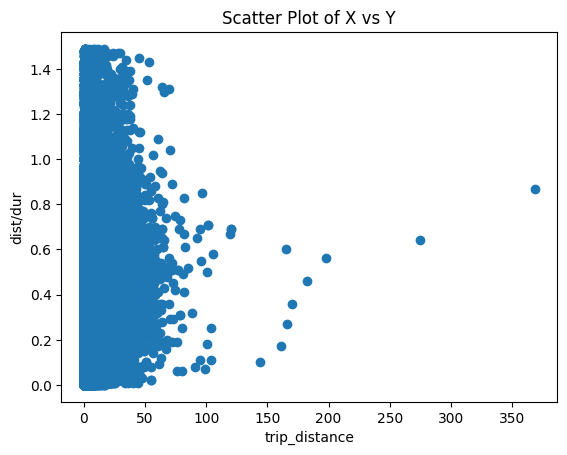

In [57]:
# Scatter plot between 'x' and 'y'
plt.scatter(df_yellow_merged['trip_distance'], df_yellow_merged['dist/dur'])

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('dist/dur')
plt.title('Scatter Plot of X vs Y')

# Display the plot
plt.show()

In [106]:
df_yellow_merged = df_yellow_merged[df_yellow_merged['dist/dur']<1.1]
len(df_yellow_merged)

37339542

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8

# Create a KDE heatmap
sns.kdeplot(
    x=df_yellow_merged['trip_distance'], 
    y=df_yellow_merged['dist/dur'], 
    cmap="viridis", 
    fill=True, 
    thresh=0
)

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('dist/dur')
plt.title('KDE Heatmap of trip_distance vs dist/dur')

# Display the heatmap
plt.show()


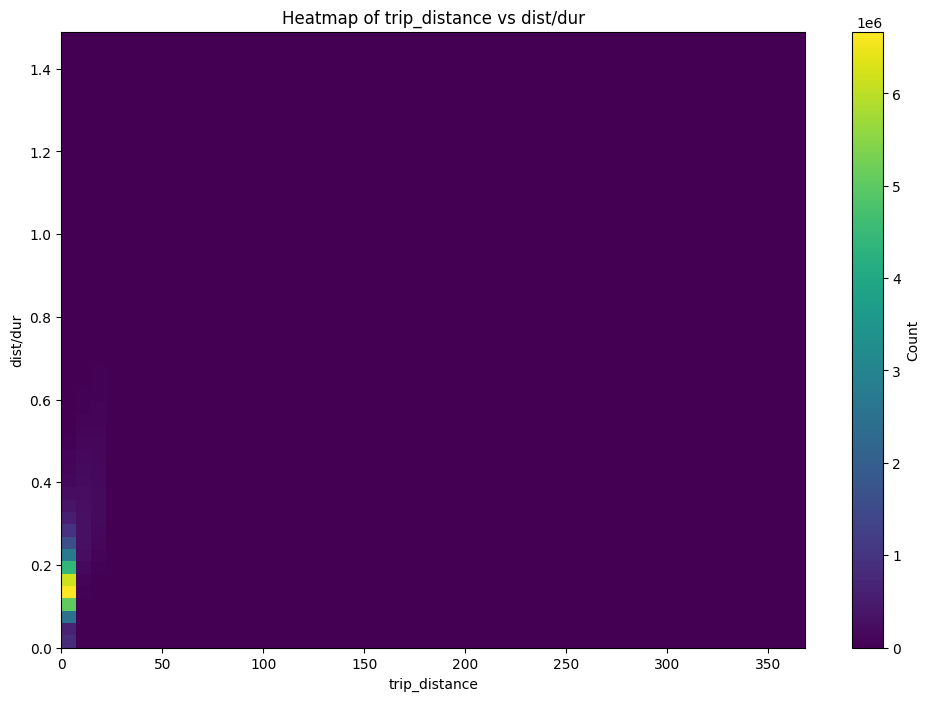

In [59]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8

# Create a 2D histogram (heatmap)
plt.hist2d(df_yellow_merged['trip_distance'], df_yellow_merged['dist/dur'], bins=50, cmap='viridis')

# Add colorbar for scale
plt.colorbar(label='Count')

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('dist/dur')
plt.title('Heatmap of trip_distance vs dist/dur')

# Display the heatmap
plt.show()


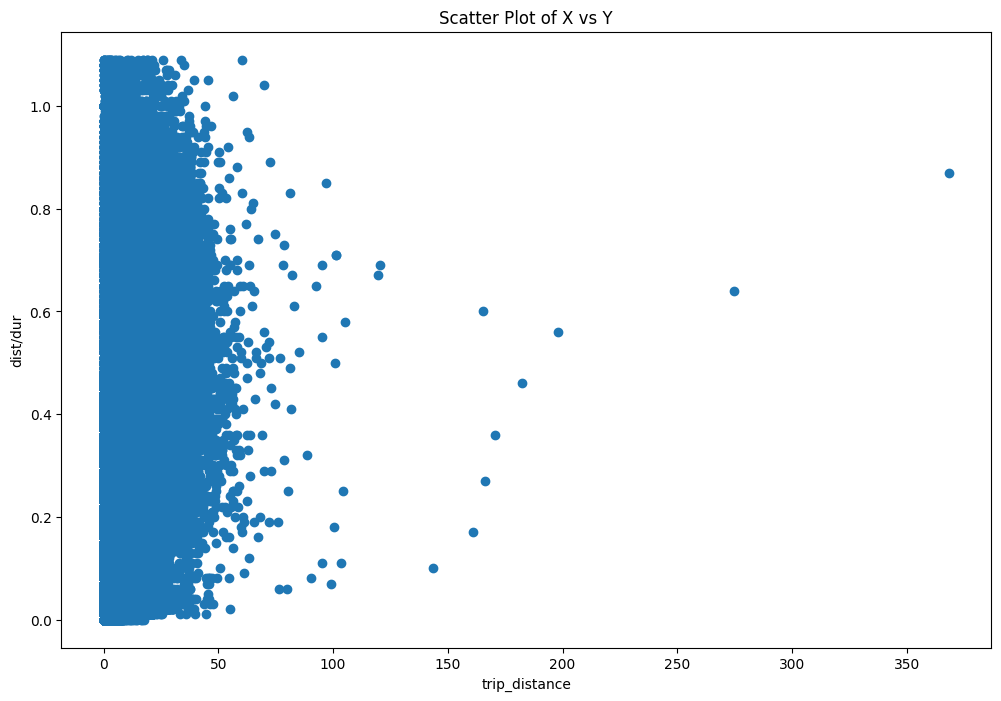

In [107]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8

# Scatter plot between 'x' and 'y'
plt.scatter(df_yellow_merged['trip_distance'], df_yellow_merged['dist/dur'])

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('dist/dur')
plt.title('Scatter Plot of X vs Y')

# Display the plot
plt.show()

In [108]:
df_yellow_merged = df_yellow_merged[df_yellow_merged['trip_distance']<50]
len(df_yellow_merged)

37339321

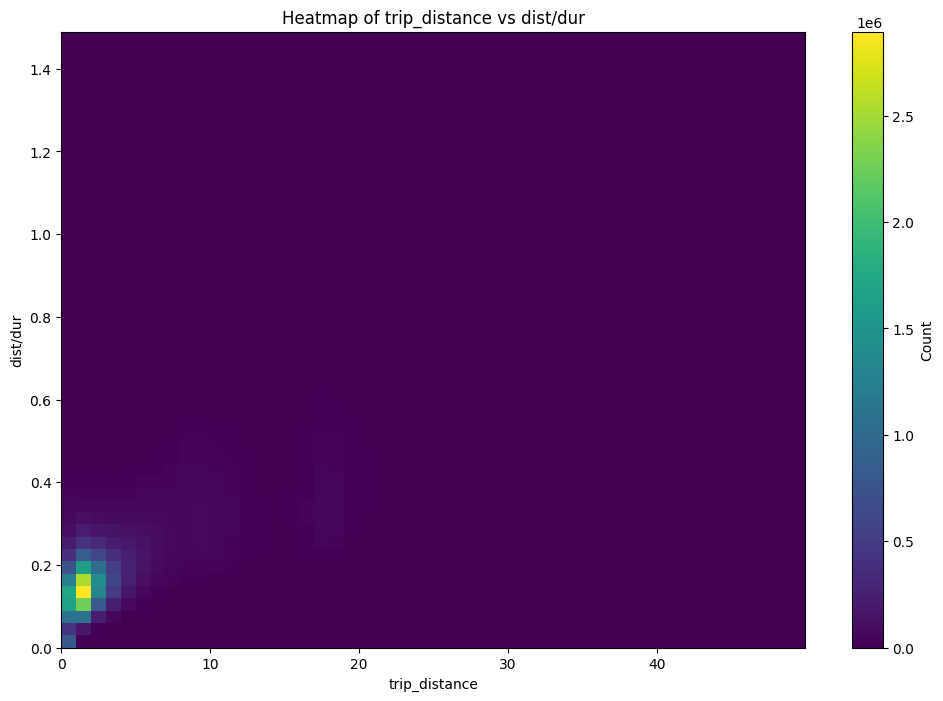

In [62]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8

# Create a 2D histogram (heatmap)
plt.hist2d(df_yellow_merged['trip_distance'], df_yellow_merged['dist/dur'], bins=50, cmap='viridis')

# Add colorbar for scale
plt.colorbar(label='Count')

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('dist/dur')
plt.title('Heatmap of trip_distance vs dist/dur')

# Display the heatmap
plt.show()


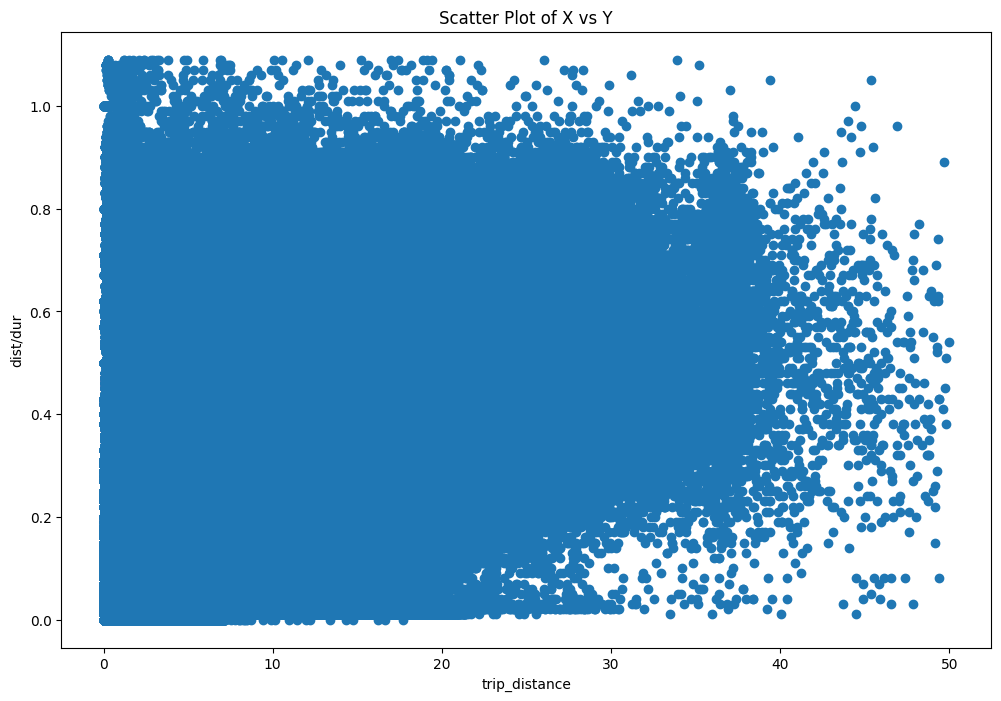

In [109]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8

# Scatter plot between 'x' and 'y'
plt.scatter(df_yellow_merged['trip_distance'], df_yellow_merged['dist/dur'])

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('dist/dur')
plt.title('Scatter Plot of X vs Y')

# Display the plot
plt.show()

In [65]:
# Example usage to find outliers in 'temperature' column
outliers_zscore = identify_outliers_zscore(df_yellow_merged, 'trip_distance')
outliers_zscore.sort_values('trip_distance')

,tpep_pickup_datetime,trip_distance,PULocationID,DOLocationID,payment_type,year,month,day,hour,minute,second,duration (min),dist/dur,MquarterN,MWeekDay,MWeekNum,temp,feelslike,dew,humidity,precip,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,icon,is holiday,Is event
13282931,2023-05-06 13:59:34,16.459999,170,132,1,2023,5,6,13,59,34,44.630001,0.37,2,6,18,19.400000,19.400000,4.3,36.970001,0.000,0.0,0.0,50.000000,10.900000,202.0,1023.299988,88.099998,14.1,779.0,2.8,8.0,5.0,4.0,0.0,0.0
27517243,2023-09-27 12:24:18,16.459999,132,164,1,2023,9,27,12,24,18,38.680000,0.43,3,3,39,18.200001,18.200001,9.3,55.869999,0.000,0.0,0.0,33.500000,18.200001,52.0,1028.099976,81.099998,16.0,512.0,1.8,5.0,5.0,4.0,0.0,0.0
9426765,2023-04-01 13:51:42,16.459999,162,132,1,2023,4,1,13,51,42,35.500000,0.46,2,6,13,16.799999,16.799999,13.4,80.400002,0.000,0.0,0.0,33.099998,20.100000,267.0,998.400024,100.000000,16.0,204.0,0.7,2.0,4.0,2.0,0.0,0.0
26988478,2023-09-18 13:07:01,16.459999,132,255,2,2023,9,18,13,7,1,50.779999,0.32,3,1,38,23.299999,23.299999,12.0,48.990002,0.000,0.0,0.0,11.200000,7.300000,213.0,1014.900024,0.800000,16.0,802.0,2.9,8.0,0.0,0.0,0.0,0.0
15464736,2023-05-25 15:51:35,16.459999,132,170,1,2023,5,25,15,51,35,51.750000,0.32,2,4,21,19.299999,19.299999,3.3,34.459999,0.000,0.0,0.0,27.700001,5.900000,8.0,1020.599976,0.400000,16.0,874.0,3.1,9.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19290138,2023-06-29 23:24:16,49.700001,132,1,2,2023,6,29,23,24,16,56.150002,0.89,2,4,26,23.799999,23.799999,17.9,69.430000,0.000,0.0,0.0,13.000000,0.200000,6.0,1017.400024,0.400000,12.7,0.0,0.0,0.0,0.0,1.0,0.0,0.0
164496,2023-01-03 11:18:53,49.740002,132,1,2,2023,1,3,11,18,53,111.480003,0.45,1,2,1,8.600000,8.600000,7.4,92.250000,2.220,0.0,0.0,11.200000,0.000000,0.0,1016.000000,100.000000,1.3,17.0,0.1,0.0,8.0,6.0,0.0,0.0
10676135,2023-04-13 18:07:11,49.799999,231,248,3,2023,4,13,18,7,11,132.130005,0.38,2,4,15,28.299999,26.900000,1.6,17.830000,0.000,0.0,0.0,38.900002,18.700001,261.0,1007.799988,7.200000,16.0,445.0,1.6,4.0,0.0,0.0,0.0,0.0
9772581,2023-04-04 20:45:39,49.830002,132,238,1,2023,4,4,20,45,39,97.830002,0.51,2,2,14,17.200001,17.200001,12.2,72.199997,0.000,0.0,0.0,20.500000,0.300000,354.0,1017.400024,27.500000,16.0,5.0,0.0,0.0,5.0,5.0,0.0,0.0


In [123]:
df_yellow_merged = df_yellow_merged[df_yellow_merged['dist/dur']<1.1]
df_yellow_merged = df_yellow_merged[df_yellow_merged['trip_distance']<40]
len(df_yellow_merged)

37338680

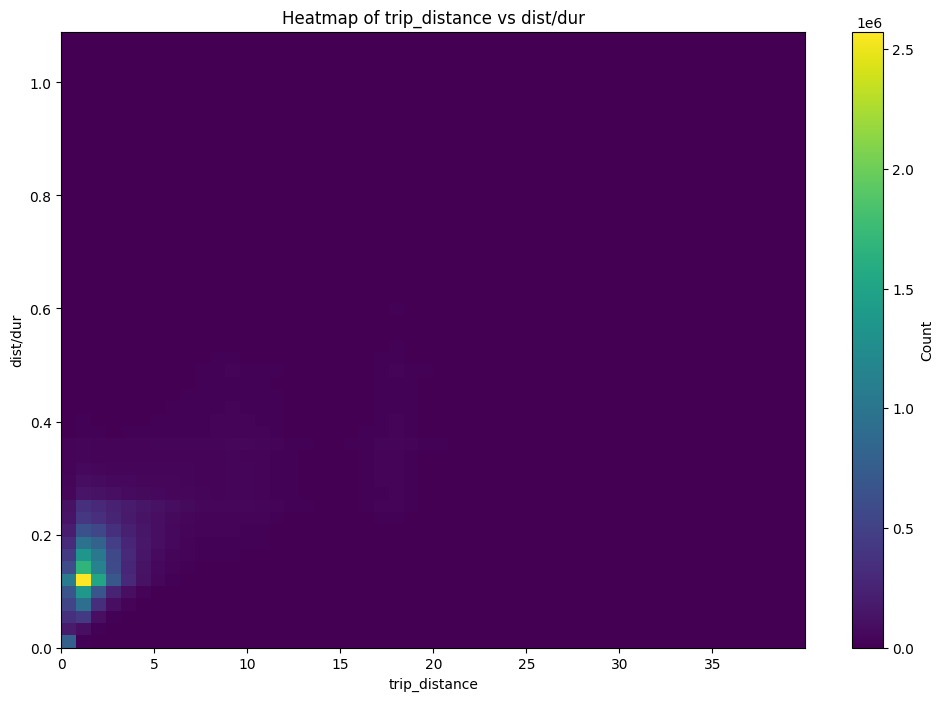

In [67]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8

# Create a 2D histogram (heatmap)
plt.hist2d(df_yellow_merged['trip_distance'], df_yellow_merged['dist/dur'], bins=50, cmap='viridis')

# Add colorbar for scale
plt.colorbar(label='Count')

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('dist/dur')
plt.title('Heatmap of trip_distance vs dist/dur')

# Display the heatmap
plt.show()


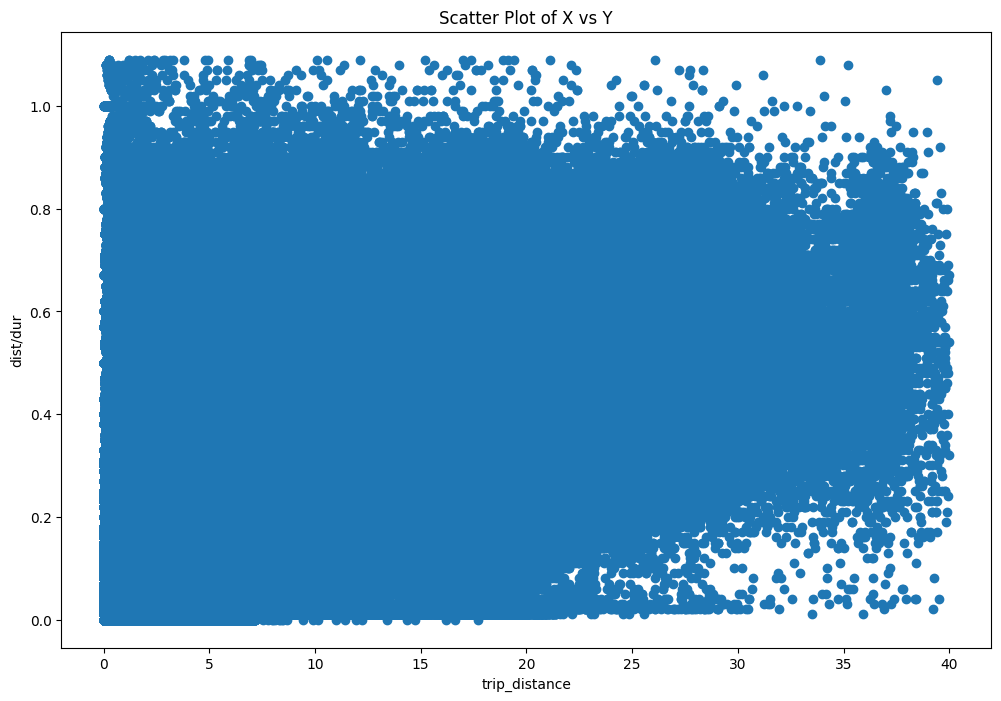

In [68]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8

# Scatter plot between 'x' and 'y'
plt.scatter(df_yellow_merged['trip_distance'], df_yellow_merged['dist/dur'])

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('dist/dur')
plt.title('Scatter Plot of X vs Y')

# Display the plot
plt.show()

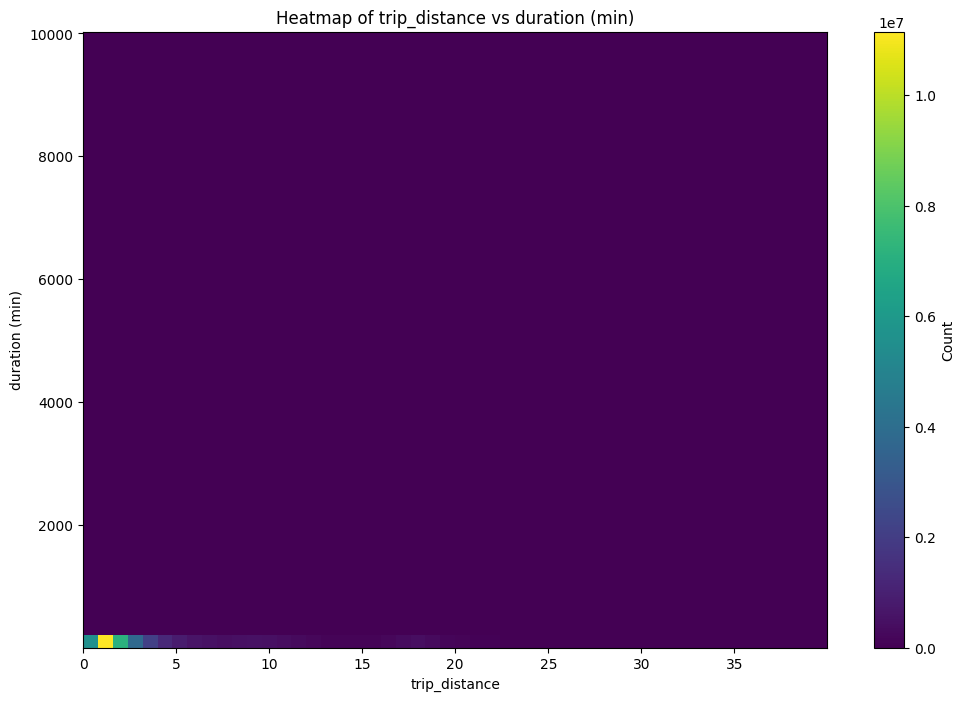

In [69]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8

# Create a 2D histogram (heatmap)
plt.hist2d(df_yellow_merged['trip_distance'], df_yellow_merged['duration (min)'], bins=50, cmap='viridis')

# Add colorbar for scale
plt.colorbar(label='Count')

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('duration (min)')
plt.title('Heatmap of trip_distance vs duration (min)')

# Display the heatmap
plt.show()


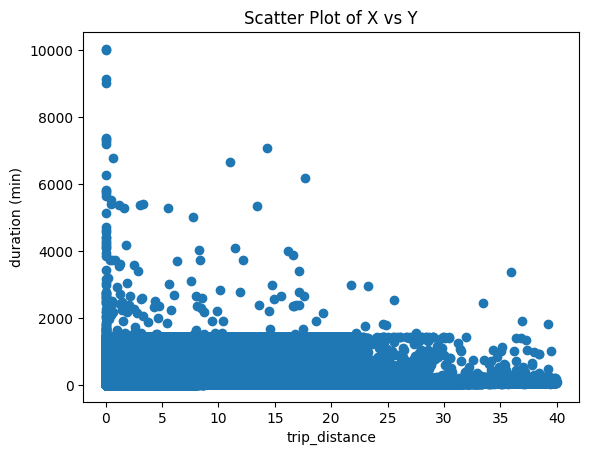

In [70]:
# Scatter plot between 'x' and 'y'
plt.scatter(df_yellow_merged['trip_distance'], df_yellow_merged['duration (min)'])

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('duration (min)')
plt.title('Scatter Plot of X vs Y')

# Display the plot
plt.show()

In [124]:
df_yellow_merged = df_yellow_merged[df_yellow_merged['duration (min)']<1800]
len(df_yellow_merged)

37338537

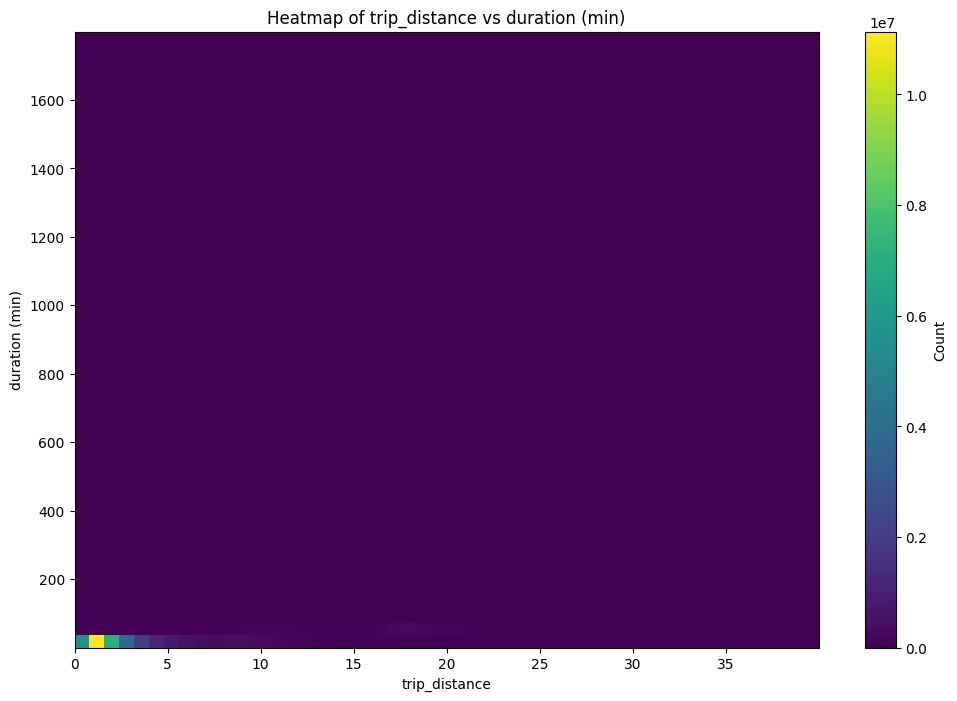

In [72]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8

# Create a 2D histogram (heatmap)
plt.hist2d(df_yellow_merged['trip_distance'], df_yellow_merged['duration (min)'], bins=50, cmap='viridis')

# Add colorbar for scale
plt.colorbar(label='Count')

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('duration (min)')
plt.title('Heatmap of trip_distance vs duration (min)')

# Display the heatmap
plt.show()


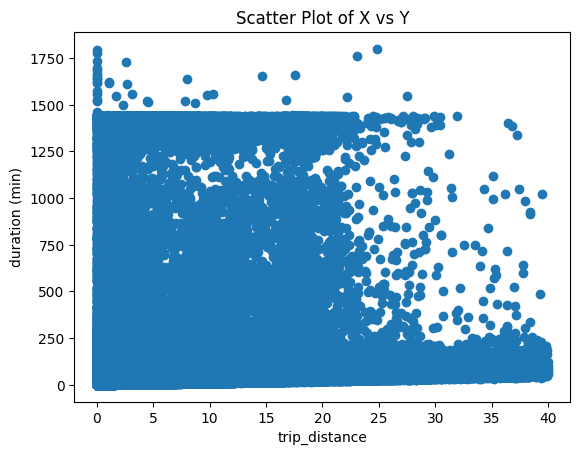

In [73]:
# Scatter plot between 'x' and 'y'
plt.scatter(df_yellow_merged['trip_distance'], df_yellow_merged['duration (min)'])

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('duration (min)')
plt.title('Scatter Plot of X vs Y')

# Display the plot
plt.show()

In [125]:
# Example usage to find outliers in 'temperature' column
outliers_zscore = identify_outliers_zscore(df_yellow_merged, 'duration (min)')
outliers_zscore.sort_values('duration (min)')

,tpep_pickup_datetime,trip_distance,PULocationID,DOLocationID,payment_type,year,month,day,hour,minute,second,duration (min),dist/dur,MquarterN,MWeekDay,MWeekNum,temp,feelslike,dew,humidity,precip,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,icon,is holiday,Is event
6714344,2023-03-08 12:01:46,26.480000,132,193,2,2023,3,8,12,1,46,138.320007,0.19,1,3,10,5.6,4.3,-5.1,46.299999,0.000,0.0,0.30,40.200001,6.400000,323.0,1020.900024,0.4,16.0,735.0,2.6,7.0,0.0,0.0,0.0,0.0
35099956,2023-12-05 11:04:49,19.400000,68,51,1,2023,12,5,11,4,49,138.330002,0.14,4,2,49,5.6,3.2,-3.9,50.330002,0.000,0.0,0.00,18.400000,11.200000,300.0,1018.000000,1.5,16.0,255.0,0.9,3.0,0.0,0.0,0.0,0.0
22729435,2023-08-06 16:36:24,16.030001,233,132,2,2023,8,6,16,36,24,138.350006,0.12,3,7,32,28.9,28.9,15.5,44.360001,0.000,0.0,0.00,16.600000,11.100000,199.0,1015.599976,0.8,15.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14789053,2023-05-20 12:54:13,20.360001,132,230,2,2023,5,20,12,54,13,138.350006,0.15,2,6,20,15.5,15.5,14.2,92.220001,0.383,0.0,0.00,18.400000,13.100000,62.0,1017.900024,100.0,5.2,116.0,0.4,1.0,8.0,6.0,0.0,0.0
12330494,2023-04-29 13:58:11,21.350000,68,132,1,2023,4,29,13,58,11,138.369995,0.15,2,6,17,11.3,11.3,10.7,95.779999,3.288,0.0,0.00,43.500000,13.000000,80.0,1011.900024,100.0,2.3,131.0,0.5,1.0,8.0,6.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31000996,2023-10-30 12:17:34,0.000000,207,260,2,2023,10,30,12,17,34,1735.079956,0.00,4,1,44,14.4,14.4,12.9,90.709999,0.000,0.0,0.00,18.400000,8.900000,255.0,1007.099976,100.0,10.6,264.0,1.0,3.0,4.0,2.0,0.0,0.0
32232696,2023-11-09 07:34:32,23.040001,132,189,2,2023,11,9,7,34,32,1759.520020,0.01,4,4,45,11.0,11.0,5.4,68.300003,0.000,0.0,0.00,24.100000,9.200000,174.0,1013.200012,100.0,16.0,9.0,0.0,0.0,4.0,2.0,0.0,0.0
8101324,2023-03-21 11:00:36,0.000000,207,260,2,2023,3,21,11,0,36,1776.030029,0.00,1,2,12,7.3,5.5,-1.6,53.119999,0.000,0.0,0.00,18.400000,9.400000,221.0,1028.900024,0.4,16.0,516.0,1.9,5.0,0.0,0.0,0.0,0.0
5792213,2023-02-28 12:21:28,0.000000,207,82,2,2023,2,28,12,21,28,1793.369995,0.00,1,2,9,3.2,0.1,2.7,96.209999,0.022,0.1,0.96,14.800000,12.300000,48.0,1007.299988,100.0,5.8,95.0,0.3,1.0,8.0,7.0,0.0,0.0


In [113]:
df_yellow_merged = df_yellow_merged[df_yellow_merged['duration (min)']<240]
len(df_yellow_merged)

37306321

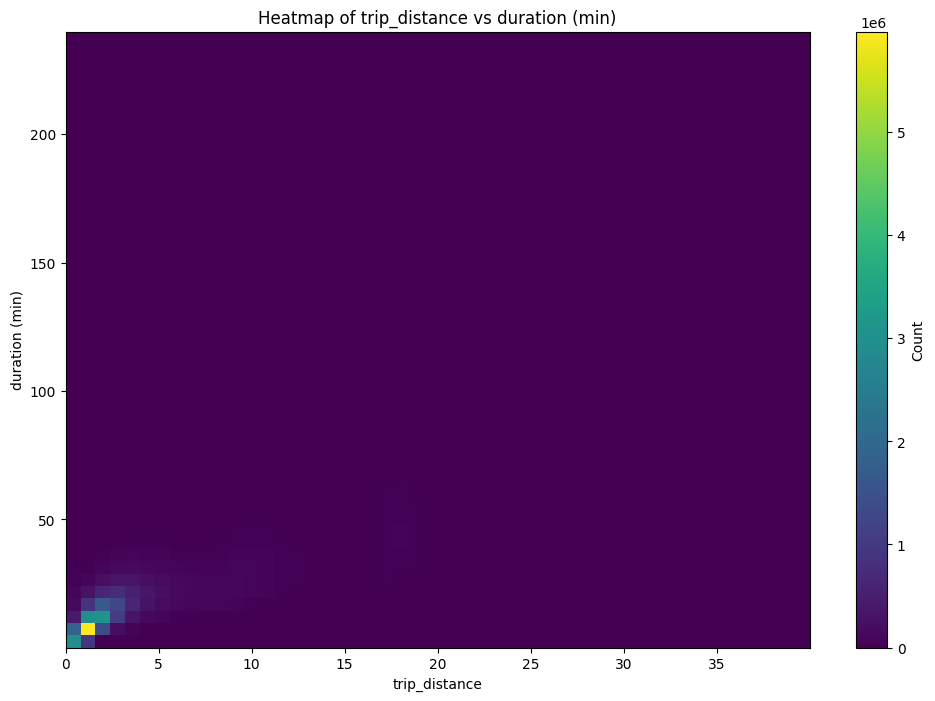

In [76]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8

# Create a 2D histogram (heatmap)
plt.hist2d(df_yellow_merged['trip_distance'], df_yellow_merged['duration (min)'], bins=50, cmap='viridis')

# Add colorbar for scale
plt.colorbar(label='Count')

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('duration (min)')
plt.title('Heatmap of trip_distance vs duration (min)')

# Display the heatmap
plt.show()


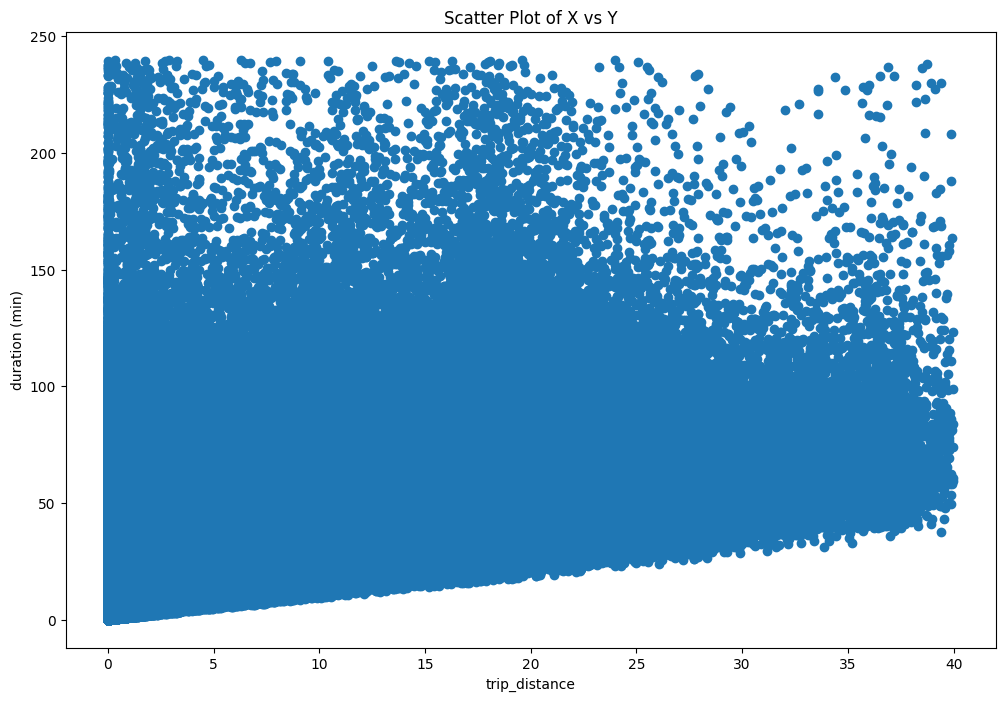

In [114]:
# Set the figure size
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8

# Scatter plot between 'x' and 'y'
plt.scatter(df_yellow_merged['trip_distance'], df_yellow_merged['duration (min)'])

# Add labels and title
plt.xlabel('trip_distance')
plt.ylabel('duration (min)')
plt.title('Scatter Plot of X vs Y')

# Display the plot
plt.show()

# Adding more features

In [60]:
# Sort by 'PULocationID' and 'tpep_pickup_datetime'
df_yellow_merged = df_yellow_merged.sort_values(by=['PULocationID', 'tpep_pickup_datetime'])

# Set the index temporarily for rolling calculation
df_yellow_merged.set_index('tpep_pickup_datetime', inplace=True)

# Calculate the rolling mean within each group using 1-hour window
df_yellow_merged['past_hour_dist/dur_avg'] = (
    df_yellow_merged.groupby('PULocationID')['dist/dur']
    .rolling('1H')
    .mean()
    .reset_index(level=0, drop=True)
)

# Reset the index back to default after calculation
df_yellow_merged.reset_index(inplace=True)

C:\Users\A\AppData\Local\Temp\ipykernel_5692\2362948622.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .rolling('1H')


In [61]:
# Sort by 'PULocationID' and 'tpep_pickup_datetime'
df_yellow_merged = df_yellow_merged.sort_values(by=['PULocationID', 'tpep_pickup_datetime'])

# Set the index temporarily for rolling calculation
df_yellow_merged.set_index('tpep_pickup_datetime', inplace=True)

# Calculate the rolling count within each group using a 1-hour window, excluding the current row
df_yellow_merged['past_hour_trips_count'] = (
    df_yellow_merged.groupby('PULocationID')['dist/dur']
    .rolling('1H', closed='left')
    .count()
    .reset_index(level=0, drop=True)
)

# Replace NaN values with 0
df_yellow_merged['past_hour_trips_count'] = df_yellow_merged['past_hour_trips_count'].fillna(0)

# Reset the index back to default after calculation
df_yellow_merged.reset_index(inplace=True)


C:\Users\A\AppData\Local\Temp\ipykernel_5692\3166798884.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .rolling('1H', closed='left')


In [62]:
df_yellow_merged = df_yellow_merged.drop(columns=['tpep_pickup_datetime', 'dist/dur'])

# optimizing memory usage by adjusting dtypes

final changes will be done after importing whole data

In [63]:
# Count rows with NaN values in any column
nan_rows_count = df_yellow_merged.isnull().any(axis=1).sum()

print(f"Number of rows with NaN values: {nan_rows_count}")


Number of rows with NaN values: 796


In [64]:
# Drop rows with any NaN values
df_yellow_merged = df_yellow_merged.dropna()

# Optional: Reset the index after dropping rows
df_yellow_merged.reset_index(drop=True, inplace=True)


In [75]:
df_yellow_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
trip_distance,47083866.0,3.342443,4.310202,0.00,1.030000,1.760000,3.320000,49.980000
PULocationID,47083866.0,164.407810,63.647222,1.00,132.000000,161.000000,233.000000,263.000000
DOLocationID,47083866.0,162.672221,69.242303,1.00,113.000000,162.000000,234.000000,263.000000
payment_type,47083866.0,1.170257,0.566746,0.00,1.000000,1.000000,1.000000,5.000000
year,47083866.0,2023.200713,0.400536,2022.00,2023.000000,2023.000000,2023.000000,2024.000000
month,47083866.0,5.649578,3.602448,1.00,3.000000,5.000000,9.000000,12.000000
day,47083866.0,15.585989,8.708753,1.00,8.000000,15.000000,23.000000,31.000000
hour,47083866.0,14.269997,5.812200,0.00,11.000000,15.000000,19.000000,23.000000
minute,47083866.0,29.568014,17.338149,0.00,14.000000,30.000000,45.000000,59.000000
second,47083866.0,29.370889,17.389690,0.00,14.000000,29.000000,44.000000,59.000000


In [76]:
df_yellow_merged.dtypes

trip_distance             float32
PULocationID               uint16
DOLocationID               uint16
payment_type                uint8
year                       uint16
month                       uint8
day                         uint8
hour                        uint8
minute                      uint8
second                      uint8
duration (min)            float32
MquarterN                   int64
MWeekDay                    int64
MWeekNum                    int64
temp                      float32
feelslike                 float32
dew                       float32
humidity                  float32
precip                    float32
snow                      float32
snowdepth                 float32
windgust                  float32
windspeed                 float32
winddir                   float32
sealevelpressure          float32
cloudcover                float32
visibility                float32
solarradiation            float32
solarenergy               float32
uvindex       

---

In [65]:
x = df_yellow_merged.drop(columns=['duration (min)'])
y = df_yellow_merged['duration (min)']

In [66]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()
x_norm = pd.DataFrame(scaler.fit_transform(x), 
                                     columns=x.columns, 
                                     index=x.index)

In [66]:
# Get memory usage for each column (in bytes) before converting dtypes
memory_usage = x_norm.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()

print(total_memory_usage)

841147572


In [67]:
# optimizing the dataframe by changing some dtypes
# converting 'float64' variables to 'float16' 
for col in x_norm.columns:
    if x_norm[col].dtype == 'float64':
        x_norm = x_norm.assign(**{col: x_norm[col].astype('float32')})

In [68]:
# Get memory usage for each column (in bytes) after converting 'int64' to 'int32' and 'float64' to 'float32'
memory_usage = x_norm.memory_usage(deep=True)
total_memory_usage = memory_usage.sum()

print(total_memory_usage)

420573852


In [68]:
x_norm_jt = x_norm.iloc[:, :10]

---

after importing whole data we will manually split the train and test data due to date (our test data will be 2024 data)

In [ ]:
#from dask_ml.model_selection import train_test_split

# Split the data (e.g., 80% training, 20% testing)
#X_train, X_test, y_train, y_test = train_test_split(x_scaled, df_yellow_merged_norm['duration (min)'], test_size=0.2, random_state=42)


In short, you can use float16, but be mindful of the potential for numerical instability. If you are working on a GPU, mixed precision training is a more efficient and safer option. If you're on a CPU, it's better to stick with float32.

---

# PCA

just travels

In [126]:
## just travels
pca = PCA()
pca.fit(x_norm_jt)

# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

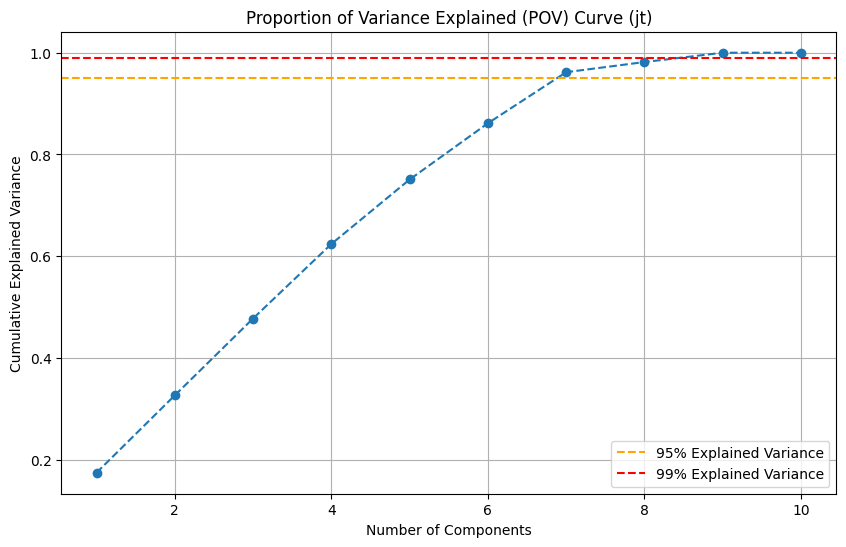

In [127]:
## just travels
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Proportion of Variance Explained (POV) Curve (jt)')
plt.grid()

# Optional: add a horizontal line at 0.95 for 95% variance threshold
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Explained Variance')
plt.legend()

plt.show()

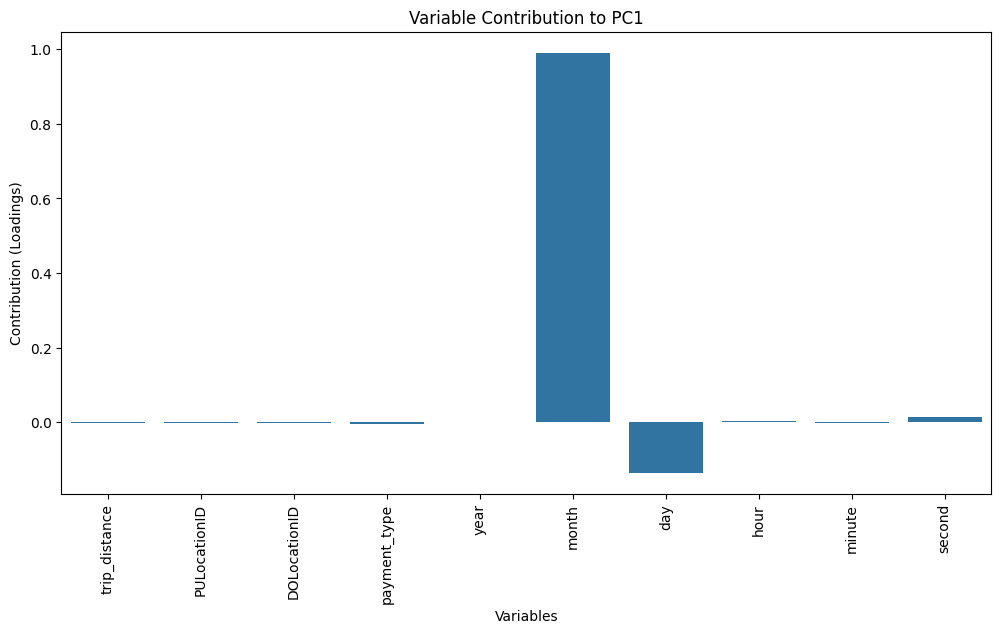

In [91]:
## just travels
# Loadings as DataFrame
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(x_norm_jt.shape[1])], index=x_norm_jt.columns)

# Choose the principal component to visualize (e.g., PC1)
pc_to_visualize = 1  # Change this to visualize different PCs

plt.figure(figsize=(12, 6))
sns.barplot(x=loadings.index, y=loadings[f'PC{pc_to_visualize}'])
plt.xticks(rotation=90)
plt.title(f'Variable Contribution to PC{pc_to_visualize}')
plt.xlabel('Variables')
plt.ylabel('Contribution (Loadings)')
plt.show()


In [91]:
## just travels
# Assuming `pca` is your PCA object and you have already fit it to your data
cumulative_variance = np.cumsum(pca.explained_variance_ratio_).tolist()

print("Cumulative explained variance for each component:", cumulative_variance)


Cumulative explained variance for each component: [0.174380362033844, 0.3264186680316925, 0.4775398373603821, 0.6239933967590332, 0.7507943511009216, 0.8613631129264832, 0.9617404937744141, 0.9816905856132507, 1.0, 1.0]


In [70]:
## just travels
# Fit PCA with the desired number of components
pca = PCA(n_components=9)
x_pca_jt = pca.fit_transform(x_norm_jt)  # x_scaled is your original dataset

# x_pca_jt is now your data reduced to the top n_components principal components
print("Shape of x_pca_jt:", x_pca_jt.shape)  # Should be (num_samples, n_components)

Shape of x_pca_jt: (37305525, 9)


with additional variables

In [128]:
## with additional
pca = PCA()
pca.fit(x_norm)

# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

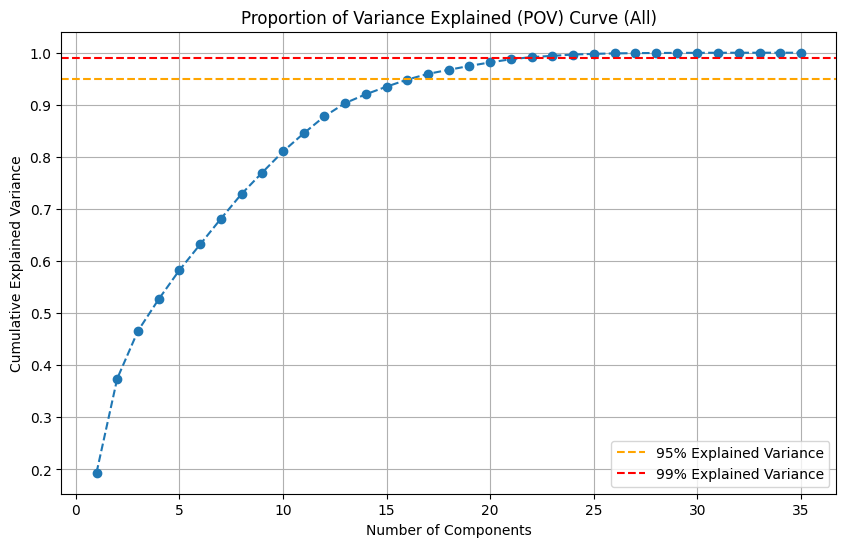

In [129]:
## with additional
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Proportion of Variance Explained (POV) Curve (All)')
plt.grid()

# Optional: add a horizontal line at 0.95 for 95% variance threshold
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Explained Variance')
plt.legend()

plt.show()

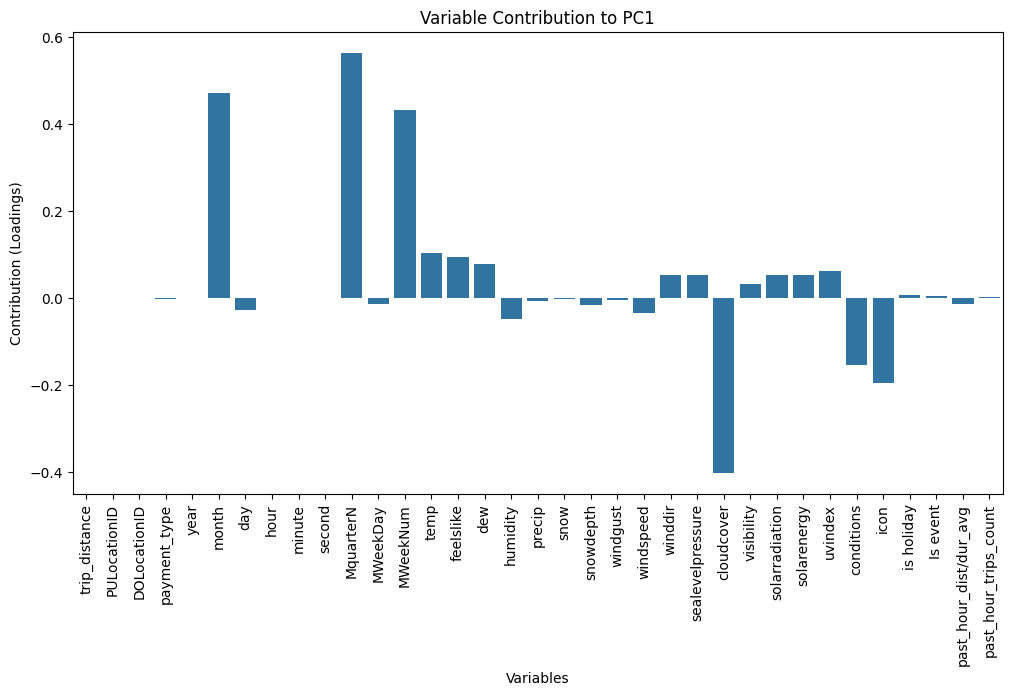

In [96]:
## with additional
# Loadings as DataFrame
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(x_norm.shape[1])], index=x_norm.columns)

# Choose the principal component to visualize (e.g., PC1)
pc_to_visualize = 1  # Change this to visualize different PCs

plt.figure(figsize=(12, 6))
sns.barplot(x=loadings.index, y=loadings[f'PC{pc_to_visualize}'])
plt.xticks(rotation=90)
plt.title(f'Variable Contribution to PC{pc_to_visualize}')
plt.xlabel('Variables')
plt.ylabel('Contribution (Loadings)')
plt.show()


In [95]:
## with additional
# Assuming `pca` is your PCA object and you have already fit it to your data
cumulative_variance = np.cumsum(pca.explained_variance_ratio_).tolist()

print("Cumulative explained variance for each component:", cumulative_variance)


Cumulative explained variance for each component: [0.19373303651809692, 0.3744644522666931, 0.4659574329853058, 0.5267066955566406, 0.5825673937797546, 0.6320162415504456, 0.6811715364456177, 0.7289242744445801, 0.7700543403625488, 0.8103819489479065, 0.8452469110488892, 0.877835214138031, 0.9033107757568359, 0.9202864766120911, 0.9348844885826111, 0.948421835899353, 0.9594356417655945, 0.9671900868415833, 0.9746789336204529, 0.9814846515655518, 0.9874476194381714, 0.9915857315063477, 0.9940415024757385, 0.9964573979377747, 0.9978256225585938, 0.998699426651001, 0.9992190599441528, 0.999492883682251, 0.9996767044067383, 0.9998015761375427, 0.9999067783355713, 0.9999635815620422, 0.9999916553497314, 0.9999997615814209, 0.9999997615814209]


In [72]:
## with additional
# Fit PCA with the desired number of components
pca = PCA(n_components=27)
x_pca = pca.fit_transform(x_norm)  # x_scaled is your original dataset

# x_pca is now your data reduced to the top n_components principal components
print("Shape of x_pca:", x_pca.shape)  # Should be (num_samples, n_components)

Shape of x_pca: (37305525, 27)


---

# keras

In [118]:
df_yellow_merged[df_yellow_merged['year']==2024]

,trip_distance,PULocationID,DOLocationID,payment_type,year,month,day,hour,minute,second,duration (min),MquarterN,MWeekDay,MWeekNum,temp,feelslike,dew,humidity,precip,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,icon,is holiday,Is event,past_hour_dist/dur_avg,past_hour_trips_count
4454,0.00,1,1,1,2024,1,1,5,54,58,0.10,1,1,1,5.0,3.3,-0.7,66.739998,0.0,0.0,0.0,7.6,7.2,253.0,1015.799988,99.0,16.0,0.0,0.0,0.0,4.0,2.0,1.0,0.0,0.000000,0.0
4455,0.06,1,1,1,2024,1,1,6,56,45,0.12,1,1,1,5.0,3.3,-0.7,66.639999,0.0,0.0,0.0,7.6,7.6,262.0,1016.299988,100.0,16.0,0.0,0.0,0.0,4.0,2.0,1.0,0.0,0.500000,0.0
4456,0.00,1,1,4,2024,1,1,6,57,44,0.20,1,1,1,5.0,3.3,-0.7,66.639999,0.0,0.0,0.0,7.6,7.6,262.0,1016.299988,100.0,16.0,0.0,0.0,0.0,4.0,2.0,1.0,0.0,0.250000,1.0
4457,0.00,1,1,4,2024,1,1,6,57,44,0.20,1,1,1,5.0,3.3,-0.7,66.639999,0.0,0.0,0.0,7.6,7.6,262.0,1016.299988,100.0,16.0,0.0,0.0,0.0,4.0,2.0,1.0,0.0,0.166667,1.0
4458,0.00,1,1,1,2024,1,1,6,59,32,0.07,1,1,1,5.0,3.3,-0.7,66.639999,0.0,0.0,0.0,7.6,7.6,262.0,1016.299988,100.0,16.0,0.0,0.0,0.0,4.0,2.0,1.0,0.0,0.125000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083861,1.40,263,140,1,2024,3,31,23,47,33,4.57,1,7,14,12.3,12.3,-0.1,42.570000,0.0,0.0,0.0,13.0,5.1,259.0,1015.000000,3.0,16.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.247586,28.0
47083862,0.50,263,262,1,2024,3,31,23,48,42,4.00,1,7,14,12.3,12.3,-0.1,42.570000,0.0,0.0,0.0,13.0,5.1,259.0,1015.000000,3.0,16.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.243333,29.0
47083863,3.10,263,230,1,2024,3,31,23,55,9,13.55,1,7,14,12.3,12.3,-0.1,42.570000,0.0,0.0,0.0,13.0,5.1,259.0,1015.000000,3.0,16.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.251429,27.0
47083864,2.79,263,170,1,2024,3,31,23,57,35,7.63,1,7,14,12.3,12.3,-0.1,42.570000,0.0,0.0,0.0,13.0,5.1,259.0,1015.000000,3.0,16.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.257692,25.0


In [74]:
# setting PCA x data
#x_train_pca_jt_np = x_pca_jt[:9450395]
#x_test_pca_jt_np = x_pca_jt[9450395:]

# setting PCA x data
#x_train_pca_np = x_pca[:9450395]
#x_test_pca_np = x_pca[9450395:]

# setting non_PCA x data
#x_train_np = x_norm.iloc[:9450395].to_numpy()
#x_test_np = x_norm.iloc[9450395:].to_numpy()

# setting response variable
#y_train_np = y.iloc[:9450395].to_numpy()
#y_test_np = y.iloc[9450395:].to_numpy()

In [73]:
# splitting train and validation
x_train_pca_np2, x_test_pca_np, y_train_np2, y_test_np = train_test_split(x_pca, y, random_state=2, test_size=0.20)
x_train_pca_jt_np2, x_test_pca_jt_np, y_train_np2, y_test_np = train_test_split(x_pca_jt, y, random_state=2, test_size=0.20)

# # splitting train and validation
x_train_pca_np, x_val_pca_np, y_train_np, y_val_np = train_test_split(x_train_pca_np2, y_train_np2, random_state=2, test_size=0.1875)
x_train_pca_jt_np, x_val_pca_jt_np, y_train_np, y_val_np = train_test_split(x_train_pca_jt_np2, y_train_np2, random_state=2, test_size=0.1875)


---

In [74]:
def plot_training_validation_loss(training_losses, validation_losses, title="Training and Validation"):
    """
    Plots the training and validation loss over epochs.

    Parameters:
    - training_losses: List of training loss values recorded per epoch.
    - validation_losses: List of validation loss values recorded per epoch.
    - title: Title of the plot (default: "Training and Validation Loss Over Epochs").
    """
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Negative Log-Likelihood Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [75]:
def extract_ci(predictions, num_components, output_dim, confidence_level=0.95):
    """
    Extract confidence intervals from MDN predictions.
    :param predictions: MDN predictions, shape [batch_size, num_components * (2 * output_dim + 1)].
    :param num_components: Number of Gaussian components.
    :param output_dim: Dimension of the output.
    :param confidence_level: Confidence level (default: 95%).
    :return: Alpha, means, lower bounds, and upper bounds of CI.
    """
    # Extract mixture weights, means, and standard deviations
    alpha = predictions[:, :num_components]  # Shape: [batch_size, num_components]
    mu = np.reshape(predictions[:, num_components:num_components + num_components * output_dim],
                    [-1, num_components, output_dim])  # Shape: [batch_size, num_components, output_dim]
    sigma = np.reshape(predictions[:, num_components + num_components * output_dim:],
                       [-1, num_components, output_dim])  # Shape: [batch_size, num_components, output_dim]

    # Ensure reshaped dimensions are correct
    assert mu.shape == (predictions.shape[0], num_components, output_dim), "Shape of mu is incorrect"
    assert sigma.shape == (predictions.shape[0], num_components, output_dim), "Shape of sigma is incorrect"

    # Weighted average of means
    means = np.sum(alpha[:, :, np.newaxis] * mu, axis=1)  # Shape: [batch_size, output_dim]

    # Compute z-score for the given confidence level (two-tailed)
    z = norm.ppf((1 + confidence_level) / 2)

    # Compute confidence intervals for each Gaussian component
    lower_bounds = mu - z * sigma  # Shape: [batch_size, num_components, output_dim]
    upper_bounds = mu + z * sigma  # Shape: [batch_size, num_components, output_dim]

    # Clip lower bounds to ensure they are non-negative
    lower_bounds = np.maximum(lower_bounds, 0)

    return alpha, mu, lower_bounds, upper_bounds

###################################################################################################################################

def compute_weighted_average(alpha, means, lower_bounds, upper_bounds):
    """
    Computes the weighted average for means, lower bounds, and upper bounds.

    Parameters:
    - alpha: Mixture weights, shape [batch_size, num_components].
    - means: Means of the Gaussian components, shape [batch_size, num_components, output_dim].
    - lower_bounds: Lower bounds of the Gaussian components, shape [batch_size, num_components, output_dim].
    - upper_bounds: Upper bounds of the Gaussian components, shape [batch_size, num_components, output_dim].

    Returns:
    - weighted_means: Weighted average of the means, shape [batch_size, output_dim].
    - weighted_lower_bounds: Weighted average of the lower bounds, shape [batch_size, output_dim].
    - weighted_upper_bounds: Weighted average of the upper bounds, shape [batch_size, output_dim].
    """
    # Compute weighted means
    weighted_means = np.sum(alpha[:, :, np.newaxis] * means, axis=1)  # Shape: [batch_size, output_dim]

    # Compute weighted bounds
    weighted_lower_bounds = np.sum(alpha[:, :, np.newaxis] * lower_bounds, axis=1)  # Shape: [batch_size, output_dim]
    weighted_upper_bounds = np.sum(alpha[:, :, np.newaxis] * upper_bounds, axis=1)  # Shape: [batch_size, output_dim]

    # Clip weighted lower bounds to ensure they are non-negative
    weighted_lower_bounds = np.maximum(weighted_lower_bounds, 0)

    return weighted_means, weighted_lower_bounds, weighted_upper_bounds

##################################################################################################################################

# Example usage
def compute_final_predictions(predictions, num_components, output_dim, confidence_level=0.95):
    """
    Computes the final weighted means and confidence intervals for predictions.

    :param predictions: MDN predictions, shape [batch_size, num_components * (2 * output_dim + 1)].
    :param num_components: Number of Gaussian components.
    :param output_dim: Dimension of the output.
    :param confidence_level: Confidence level (default: 95%).
    :return: Weighted means, lower bounds, and upper bounds.
    """
    # Extract components from MDN predictions
    alpha, mu, lower_bounds, upper_bounds = extract_ci(predictions, num_components, output_dim, confidence_level)

    # Compute weighted averages
    weighted_means, weighted_lower_bounds, weighted_upper_bounds = compute_weighted_average(
        alpha, mu, lower_bounds, upper_bounds
    )

    return weighted_means, weighted_lower_bounds, weighted_upper_bounds



In [76]:
tfd = tfp.distributions

def mdn_layer(num_components, output_dim):
    def mdn_model(inputs):
        # Mixture weights (alphas) with softmax activation
        alpha = layers.Dense(num_components, activation="softmax", name="mixture_weights")(inputs)
        # Clip alpha using a Lambda layer to avoid extremely small or large probabilities
        alpha = Lambda(lambda x: tf.clip_by_value(x, clip_value_min=1e-6, clip_value_max=1.0))(alpha)
        
        # Means (mu) with softplus activation to enforce non-negativity
        mu = layers.Dense(num_components * output_dim, activation="softplus", name="means")(inputs)
        
        # Variances (sigma) with softplus activation to ensure they are positive
        sigma = layers.Dense(num_components * output_dim, activation="softplus", name="variances")(inputs)
        
        return layers.Concatenate(name="mdn_outputs")([alpha, mu, sigma])
    return mdn_model


def mdn_loss(num_components, output_dim):
    def loss_fn(y_true, y_pred):
        # Reshape y_true to match the expected shape
        y_true = tf.reshape(y_true, [-1, output_dim])  # Ensure shape is [batch_size, output_dim]
        
        # Extract MDN outputs
        alpha = y_pred[:, :num_components]
        mu = tf.reshape(y_pred[:, num_components:num_components + num_components * output_dim], [-1, num_components, output_dim])
        sigma = tf.reshape(y_pred[:, num_components + num_components * output_dim:], [-1, num_components, output_dim])

        # Add a small epsilon to sigma to avoid numerical issues
        sigma = tf.clip_by_value(sigma, clip_value_min=1e-6, clip_value_max=1e3)

        # Create Gaussian Mixture Model
        gmm = tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=alpha),
            components_distribution=tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
        )

        # Compute negative log-likelihood
        nll = -gmm.log_prob(y_true)
        return tf.reduce_mean(nll)

    return loss_fn


# Callback to record loss during training
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

class CustomEarlyStopping(Callback):
    def __init__(self, patience=10, monitor='val_loss', threshold=3.0, verbose=1):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.monitor = monitor
        self.threshold = threshold
        self.verbose = verbose
        self.wait = 0
        self.best = float('inf')
        self.monitoring = False

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        # Start monitoring only when the loss is below the threshold
        if current < self.threshold:
            if not self.monitoring:
                if self.verbose:
                    print(f"Threshold reached: {self.monitor} = {current:.4f}. Starting early stopping monitoring.")
                self.monitoring = True

        if self.monitoring:
            if current < self.best:
                self.best = current
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    if self.verbose:
                        print(f"Early stopping after {self.patience} epochs with no improvement.")
                    self.model.stop_training = True


---

# main model (ICBDN)

In [132]:
# Build the MLP-MDN model
def build_mlp_mdn_model(input_dim, output_dim, num_components):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(16, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Use the modified MDN layer
    mdn_outputs = mdn_layer(num_components, output_dim)(x)
    model = Model(inputs, mdn_outputs, name="MLP_MDN")

    # Define an exponential decay learning rate schedule
    initial_learning_rate = 1e-3
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=400000,  # Number of steps before decay
        decay_rate=0.50,   # Decay rate
        staircase=True     # If True, learning rate decreases in discrete intervals
    )

    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=mdn_loss(num_components, output_dim))
    return model

# Define the EarlyStopping callback 
early_stopping = CustomEarlyStopping( 
    monitor='val_loss', # Metric to monitor 
    patience=10, # Number of epochs to wait for improvement 
    threshold=3.0, # Restore the best weights after stopping 
    verbose=1, # Print messages when stopping 
    )

# Example usage
input_dim = 24  # Number of principal components (input features)
output_dim = 1  # Predicting a single target (travel time)
num_components = 3  # Number of Gaussian components in MDN

# Instantiate the callback
loss_history1 = LossHistory()

model1 = build_mlp_mdn_model(input_dim, output_dim, num_components)
model1.summary()


Model: "MLP_MDN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_133 (Dense)   │ (None, 16)        │        400 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_134 (Dense)   │ (None, 32)        │        544 │ dense_133[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_134[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_76          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_135 (Dense)   │ (None, 64)        │      2,112 │ dropout_76[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_136 (Dense)   │ (None, 128)       │      8,320 │ dense_135[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_136[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_77          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_137 (Dense)   │ (None, 64)        │      8,256 │ dropout_77[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_138 (Dense)   │ (None, 32)        │      2,080 │ dense_137[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_138[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_78          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_139 (Dense)   │ (None, 16)        │        528 │ dropout_78[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_139[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_79          │ (None, 16)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_weights     │ (None, 3)         │         51 │ dropout_79[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_18 (Lambda)  │ (None, 3)         │          0 │ mixture_weights[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means (Dense)       │ (None, 3)         │         51 │ dropout_79[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variances (Dense)   │ (None, 3)         │         51 │ dropout_79[0][0]

 Total params: 23,225 (90.72 KB)

 Trainable params: 22,809 (89.10 KB)

 Non-trainable params: 416 (1.62 KB)

In [131]:
x_train_pca_np.shape

(24460488, 24)

Epoch 1/100
95549/95549 ━━━━━━━━━━━━━━━━━━━━ 402s 4ms/step - loss: 6.4667 - val_loss: 3.1520
Epoch 2/100
95549/95549 ━━━━━━━━━━━━━━━━━━━━ 386s 4ms/step - loss: 3.1264 - val_loss: 3.1805
Epoch 3/100
95549/95549 ━━━━━━━━━━━━━━━━━━━━ 391s 4ms/step - loss: 3.0410 - val_loss: 3.1839
Epoch 4/100
95549/95549 ━━━━━━━━━━━━━━━━━━━━ 389s 4ms/step - loss: 2.8900 - val_loss: 3.1293
Epoch 5/100
95549/95549 ━━━━━━━━━━━━━━━━━━━━ 391s 4ms/step - loss: 2.8693 - val_loss: 3.1799
Epoch 6/100
95549/95549 ━━━━━━━━━━━━━━━━━━━━ 390s 4ms/step - loss: 2.8560 - val_loss: 3.1820
Epoch 7/100
95549/95549 ━━━━━━━━━━━━━━━━━━━━ 384s 4ms/step - loss: 2.8540 - val_loss: 3.1429
Epoch 8/100
95549/95549 ━━━━━━━━━━━━━━━━━━━━ 385s 4ms/step - loss: 2.8520 - val_loss: 3.2356
Epoch 9/100
95549/95549 ━━━━━━━━━━━━━━━━━━━━ 386s 4ms/step - loss: 2.8471 - val_loss: 3.1432
Epoch 10/100
95549/95549 ━━━━━━━━━━━━━━━━━━━━ 386s 4ms/step - loss: 2.8379 - val_loss: 3.1797
Epoch 11/100
95549/95549 ━━━━━━━━━━━━━━━━━━━━ 381s 4ms/step - loss: 2

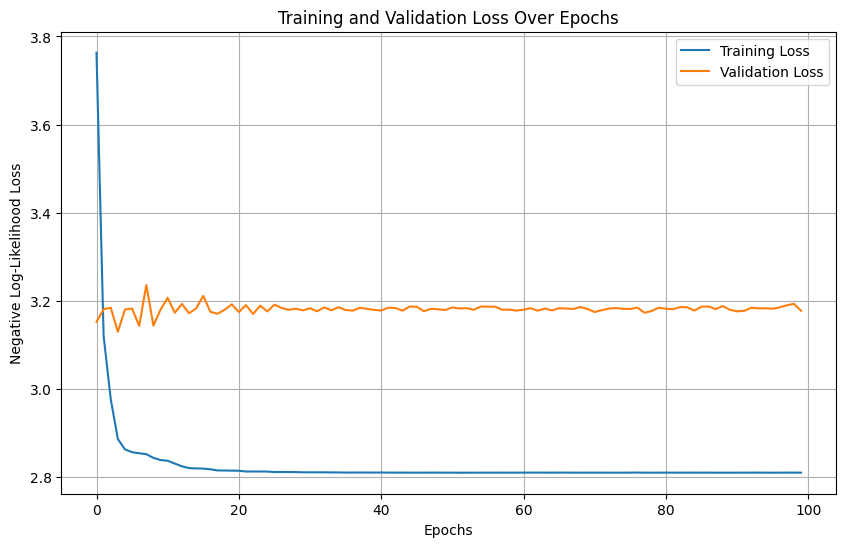

In [133]:
# Train the model1 
history1 = model1.fit(
    x_train_pca_np, y_train_np,
    validation_data=(x_val_pca_np, y_val_np),
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=[loss_history1, early_stopping]
)

# plotting the losses
plot_training_validation_loss(loss_history1.losses, loss_history1.val_losses, title="Training and Validation Loss Over Epochs")

In [82]:
# Predict
y_pred1 = model1.predict(x_test_pca_np)

# Define the loss function again if needed
loss_fn = mdn_loss(num_components, output_dim)

# Compute the loss
test_loss = loss_fn(y_test_np, y_pred1)
print(f"Test Loss: {test_loss.numpy()}")

235198/235198 ━━━━━━━━━━━━━━━━━━━━ 162s 688us/step
Test Loss: 3.2172915935516357


In [83]:
# Set confidence level and limit the number of samples
CL = 0.95
sample_count = 100  # Compute for the first 100 samples

# Extract the first 100 predictions and corresponding ground truth
y_pred1_subset = y_pred1[:sample_count]
y_test_np_subset = np.array(y_test_np[:sample_count])

# Compute weighted predictions and confidence intervals for the subset
weighted_means1_subset, weighted_lower_bounds1_subset, weighted_upper_bounds1_subset = compute_final_predictions(
    y_pred1_subset, num_components, output_dim, confidence_level=CL
)

# Flatten the arrays for easy handling
weighted_means1_subset = weighted_means1_subset.flatten()
weighted_lower_bounds1_subset = weighted_lower_bounds1_subset.flatten()
weighted_upper_bounds1_subset = weighted_upper_bounds1_subset.flatten()

# Print results for each sample with ground truth
print(f"{'Sample':<10}{'Ground Truth':<15}{'Mean Prediction':<20}{'Confidence Interval':<30}{'Interval Range':<15}")
print("-" * 90)
for i in range(sample_count):
    interval_range = float(weighted_upper_bounds1_subset[i]) - float(weighted_lower_bounds1_subset[i])
    print(f"{i+1:<10}{float(y_test_np_subset[i]):<15.2f}{float(weighted_means1_subset[i]):<20.2f}"
          f"{f'{float(weighted_lower_bounds1_subset[i]):.2f} - {float(weighted_upper_bounds1_subset[i]):.2f}':<30}"
          f"{interval_range:<15.2f}")


Sample    Ground Truth   Mean Prediction     Confidence Interval           Interval Range 
------------------------------------------------------------------------------------------
1         25.75          19.39               6.93 - 31.84                  24.91          
2         2.97           9.38                2.26 - 16.69                  14.43          
3         12.58          15.78               5.70 - 25.86                  20.16          
4         15.33          24.48               8.17 - 40.79                  32.62          
5         19.30          24.76               8.16 - 41.36                  33.20          
6         11.07          9.33                2.63 - 16.16                  13.53          
7         17.22          18.47               6.44 - 30.50                  24.06          
8         18.88          17.26               6.09 - 28.44                  22.35          
9         16.62          10.41               3.04 - 17.89                  14.85          

---

4096


In [79]:
# Build the MLP-MDN model
def build_mlp_mdn_model(input_dim, output_dim, num_components):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(16, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    
    # Use the modified MDN layer
    mdn_outputs = mdn_layer(num_components, output_dim)(x)
    model = Model(inputs, mdn_outputs, name="MLP_MDN")

    # Define an exponential decay learning rate schedule
    initial_learning_rate = 1e-3
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=25000,  # Number of steps before decay
        decay_rate=0.50,   # Decay rate
        staircase=True     # If True, learning rate decreases in discrete intervals
    )

    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=mdn_loss(num_components, output_dim))
    return model

# Define the EarlyStopping callback 
early_stopping = CustomEarlyStopping( 
    monitor='val_loss', # Metric to monitor 
    patience=10, # Number of epochs to wait for improvement 
    threshold=3.0, # Restore the best weights after stopping 
    verbose=1, # Print messages when stopping 
    )

# Example usage
input_dim = 27  # Number of principal components (input features)
output_dim = 1  # Predicting a single target (travel time)
num_components = 3  # Number of Gaussian components in MDN

# Instantiate the callback
loss_historytest4 = LossHistory()

modeltest4 = build_mlp_mdn_model(input_dim, output_dim, num_components)

In [80]:

# Train the model1 
historytest4 = modeltest4.fit(
    x_train_pca_np, y_train_np,
    validation_data=(x_val_pca_np, y_val_np),
    epochs=100,
    batch_size=4096,
    verbose=1,
    callbacks=[loss_historytest4, early_stopping]
)



Epoch 1/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - loss: 313.5559 - val_loss: 11.5426
Epoch 2/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - loss: 9.3675 - val_loss: 4.2027
Epoch 3/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 4.0873 - val_loss: 3.4988
Epoch 4/100
5918/5921 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3301Threshold reached: val_loss = 2.8327. Starting early stopping monitoring.
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - loss: 3.3300 - val_loss: 2.8327
Epoch 5/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 2.8814 - val_loss: 2.7811
Epoch 6/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - loss: 2.8126 - val_loss: 2.7630
Epoch 7/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 2.7838 - val_loss: 2.7641
Epoch 8/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 2.7580 - val_loss: 2.7616
Epoch 9/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - loss: 2.7393 - val_loss: 2.7459
Epoch 10/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step

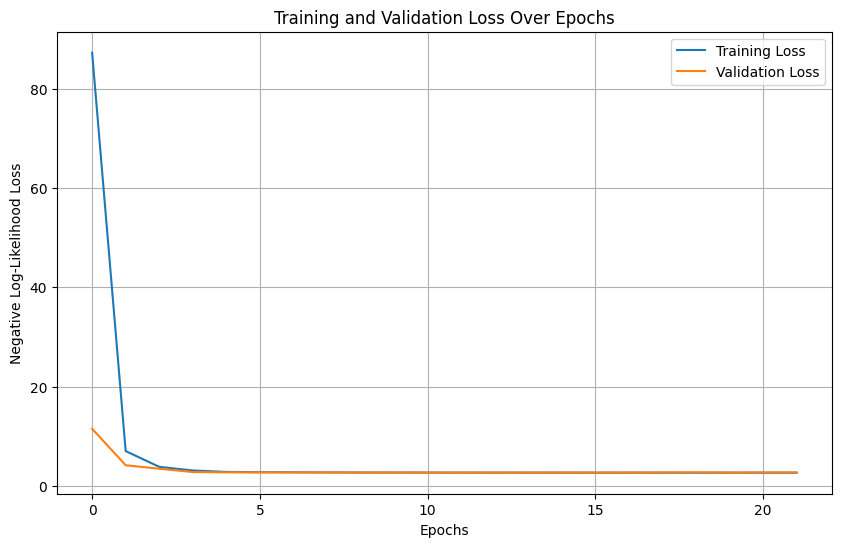

In [87]:
# plotting the losses
plot_training_validation_loss(loss_historytest4.losses, loss_historytest4.val_losses, title="Training and Validation Loss Over Epochs")

---

512

In [81]:
# Build the MLP-MDN model
def build_mlp_mdn_model(input_dim, output_dim, num_components):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(16, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    
    # Use the modified MDN layer
    mdn_outputs = mdn_layer(num_components, output_dim)(x)
    model = Model(inputs, mdn_outputs, name="MLP_MDN")

    # Define an exponential decay learning rate schedule
    initial_learning_rate = 1e-3
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=25000,  # Number of steps before decay
        decay_rate=0.50,   # Decay rate
        staircase=True     # If True, learning rate decreases in discrete intervals
    )

    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=mdn_loss(num_components, output_dim))
    return model

# Define the EarlyStopping callback 
early_stopping = CustomEarlyStopping( 
    monitor='val_loss', # Metric to monitor 
    patience=10, # Number of epochs to wait for improvement 
    threshold=3.0, # Restore the best weights after stopping 
    verbose=1, # Print messages when stopping 
    )

# Example usage
input_dim = 27  # Number of principal components (input features)
output_dim = 1  # Predicting a single target (travel time)
num_components = 1  # Number of Gaussian components in MDN

# Instantiate the callback
loss_historytest1 = LossHistory()

modeltest1 = build_mlp_mdn_model(input_dim, output_dim, num_components)

In [82]:

# Train the model1 
historytest1 = modeltest1.fit(
    x_train_pca_np, y_train_np,
    validation_data=(x_val_pca_np, y_val_np),
    epochs=100,
    batch_size=4096,
    verbose=1,
    callbacks=[loss_historytest1, early_stopping]
)



Epoch 1/100


c:\Users\A\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5921/5921 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 11063.2354 - val_loss: 227.1603
Epoch 2/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 195.3340 - val_loss: 22.8342
Epoch 3/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 20.5787 - val_loss: 4.4440
Epoch 4/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 5.0823 - val_loss: 3.6118
Epoch 5/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - loss: 3.6002 - val_loss: 3.1225
Epoch 6/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1445Threshold reached: val_loss = 2.9470. Starting early stopping monitoring.
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 3.1445 - val_loss: 2.9470
Epoch 7/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 3.0079 - val_loss: 2.9164
Epoch 8/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - loss: 2.9809 - val_loss: 2.9105
Epoch 9/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 2.9595 - val_loss: 2.9095
Epoch 10/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - lo

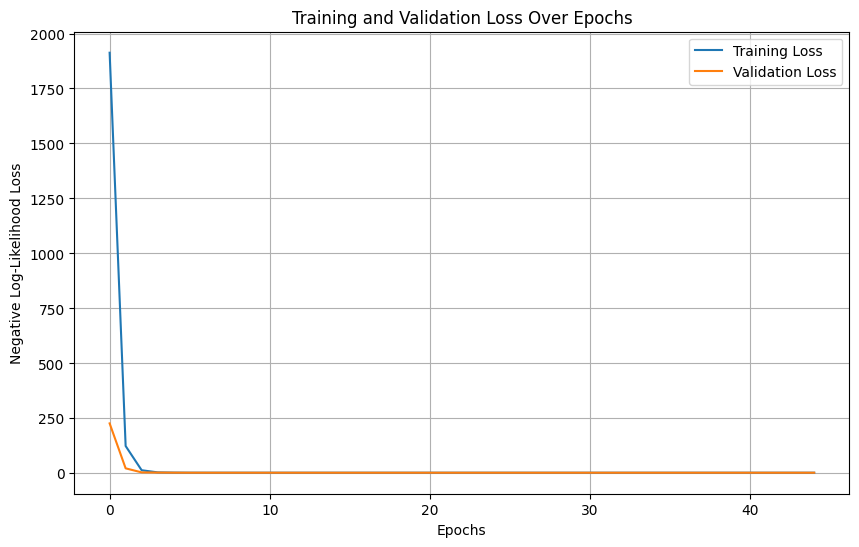

In [88]:
# plotting the losses
plot_training_validation_loss(loss_historytest1.losses, loss_historytest1.val_losses, title="Training and Validation Loss Over Epochs")

---

1024

In [83]:
# Build the MLP-MDN model
def build_mlp_mdn_model(input_dim, output_dim, num_components):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(16, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    
    # Use the modified MDN layer
    mdn_outputs = mdn_layer(num_components, output_dim)(x)
    model = Model(inputs, mdn_outputs, name="MLP_MDN")

    # Define an exponential decay learning rate schedule
    initial_learning_rate = 1e-3
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=25000,  # Number of steps before decay
        decay_rate=0.50,   # Decay rate
        staircase=True     # If True, learning rate decreases in discrete intervals
    )

    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=mdn_loss(num_components, output_dim))
    return model

# Define the EarlyStopping callback 
early_stopping = CustomEarlyStopping( 
    monitor='val_loss', # Metric to monitor 
    patience=10, # Number of epochs to wait for improvement 
    threshold=3.0, # Restore the best weights after stopping 
    verbose=1, # Print messages when stopping 
    )

# Example usage
input_dim = 27  # Number of principal components (input features)
output_dim = 1  # Predicting a single target (travel time)
num_components = 6  # Number of Gaussian components in MDN

# Instantiate the callback
loss_historytest2 = LossHistory()

modeltest2 = build_mlp_mdn_model(input_dim, output_dim, num_components)

In [84]:

# Train the model1 
historytest2 = modeltest2.fit(
    x_train_pca_np, y_train_np,
    validation_data=(x_val_pca_np, y_val_np),
    epochs=100,
    batch_size=4096,
    verbose=1,
    callbacks=[loss_historytest2, early_stopping]
)



Epoch 1/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - loss: 8.0489 - val_loss: 3.0288
Epoch 2/100
5917/5921 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0445Threshold reached: val_loss = 2.8502. Starting early stopping monitoring.
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 3.0444 - val_loss: 2.8502
Epoch 3/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - loss: 2.8439 - val_loss: 2.7926
Epoch 4/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - loss: 2.7982 - val_loss: 2.7345
Epoch 5/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 2.7667 - val_loss: 2.7082
Epoch 6/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - loss: 2.7461 - val_loss: 2.7112
Epoch 7/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - loss: 2.7292 - val_loss: 2.7356
Epoch 8/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - loss: 2.7198 - val_loss: 2.6946
Epoch 9/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - loss: 2.7107 - val_loss: 2.6833
Epoch 10/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - 

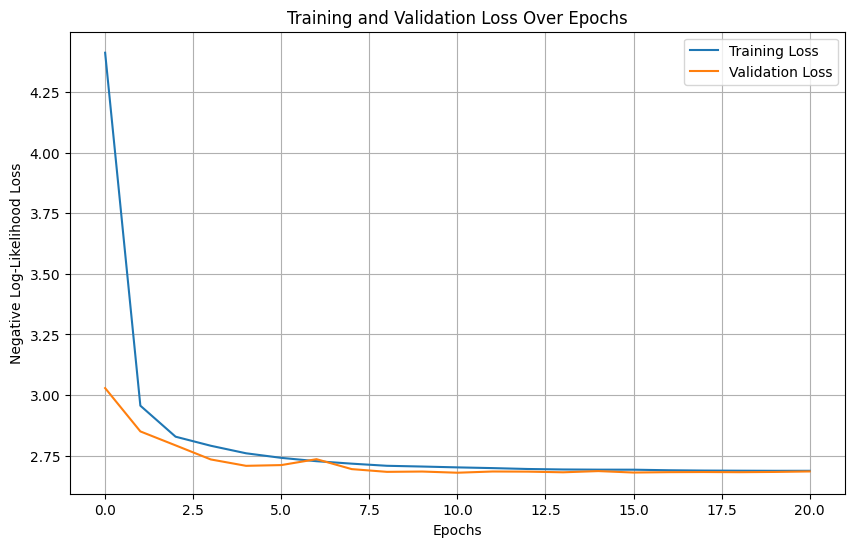

In [89]:
# plotting the losses
plot_training_validation_loss(loss_historytest2.losses, loss_historytest2.val_losses, title="Training and Validation Loss Over Epochs")

In [92]:
num_components = 6

# Predict
y_predtest2 = modeltest2.predict(x_test_pca_np)

# Define the loss function again if needed
loss_fn = mdn_loss(num_components, output_dim)

# Compute the loss
test_loss = loss_fn(y_test_np, y_predtest2)
print(f"Test Loss: {test_loss.numpy()}")

233160/233160 ━━━━━━━━━━━━━━━━━━━━ 165s 709us/step
Test Loss: 2.6854140758514404


In [93]:
# Set confidence level and limit the number of samples
CL = 0.95
sample_count = 100  # Compute for the first 100 samples

# Extract the first 100 predictions and corresponding ground truth
y_predtest2_subset = y_predtest2[:sample_count]
y_test_np_subset = np.array(y_test_np[:sample_count])

# Compute weighted predictions and confidence intervals for the subset
weighted_meanstest2_subset, weighted_lower_boundstest2_subset, weighted_upper_boundstest2_subset = compute_final_predictions(
    y_predtest2_subset, num_components, output_dim, confidence_level=CL
)

# Flatten the arrays for easy handling
weighted_meanstest2_subset = weighted_meanstest2_subset.flatten()
weighted_lower_boundstest2_subset = weighted_lower_boundstest2_subset.flatten()
weighted_upper_boundstest2_subset = weighted_upper_boundstest2_subset.flatten()

# Print results for each sample with ground truth
print(f"{'Sample':<10}{'Ground Truth':<15}{'Mean Prediction':<20}{'Confidence Interval':<30}{'Interval Range':<15}")
print("-" * 90)
for i in range(sample_count):
    interval_range = float(weighted_upper_boundstest2_subset[i]) - float(weighted_lower_boundstest2_subset[i])
    print(f"{i+1:<10}{float(y_test_np_subset[i]):<15.2f}{float(weighted_meanstest2_subset[i]):<20.2f}"
          f"{f'{float(weighted_lower_boundstest2_subset[i]):.2f} - {float(weighted_upper_boundstest2_subset[i]):.2f}':<30}"
          f"{interval_range:<15.2f}")


Sample    Ground Truth   Mean Prediction     Confidence Interval           Interval Range 
------------------------------------------------------------------------------------------
1         18.42          20.79               12.11 - 29.48                 17.37          
2         9.63           8.73                5.34 - 12.13                  6.79           
3         14.47          24.44               12.96 - 35.92                 22.96          
4         33.35          38.96               23.65 - 54.26                 30.61          
5         9.00           9.35                5.85 - 12.86                  7.01           
6         8.02           10.94               7.07 - 14.82                  7.75           
7         7.05           6.82                4.05 - 9.59                   5.54           
8         7.70           15.31               7.86 - 22.78                  14.92          
9         15.02          19.32               10.72 - 27.92                 17.20          

---

2048

In [85]:
# Build the MLP-MDN model
def build_mlp_mdn_model(input_dim, output_dim, num_components):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(16, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    
    # Use the modified MDN layer
    mdn_outputs = mdn_layer(num_components, output_dim)(x)
    model = Model(inputs, mdn_outputs, name="MLP_MDN")

    # Define an exponential decay learning rate schedule
    initial_learning_rate = 1e-3
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=25000,  # Number of steps before decay
        decay_rate=0.50,   # Decay rate
        staircase=True     # If True, learning rate decreases in discrete intervals
    )

    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=mdn_loss(num_components, output_dim))
    return model

# Define the EarlyStopping callback 
early_stopping = CustomEarlyStopping( 
    monitor='val_loss', # Metric to monitor 
    patience=10, # Number of epochs to wait for improvement 
    threshold=3.0, # Restore the best weights after stopping 
    verbose=1, # Print messages when stopping 
    )

# Example usage
input_dim = 27  # Number of principal components (input features)
output_dim = 1  # Predicting a single target (travel time)
num_components = 10  # Number of Gaussian components in MDN

# Instantiate the callback
loss_historytest3 = LossHistory()

modeltest3 = build_mlp_mdn_model(input_dim, output_dim, num_components)

In [86]:

# Train the model1 
historytest3 = modeltest3.fit(
    x_train_pca_np, y_train_np,
    validation_data=(x_val_pca_np, y_val_np),
    epochs=100,
    batch_size=4096,
    verbose=1,
    callbacks=[loss_historytest3, early_stopping]
)



Epoch 1/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - loss: 7.7585 - val_loss: 3.1015
Epoch 2/100
5916/5921 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9480Threshold reached: val_loss = 2.7918. Starting early stopping monitoring.
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - loss: 2.9479 - val_loss: 2.7918
Epoch 3/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 2.8074 - val_loss: 2.8356
Epoch 4/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 2.7565 - val_loss: 2.7749
Epoch 5/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 2.7377 - val_loss: 2.7549
Epoch 6/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - loss: 2.7289 - val_loss: 2.7638
Epoch 7/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 2.7227 - val_loss: 2.7717
Epoch 8/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - loss: 2.7158 - val_loss: 2.7424
Epoch 9/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 2.7094 - val_loss: 2.8245
Epoch 10/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 55s 9ms/step - 

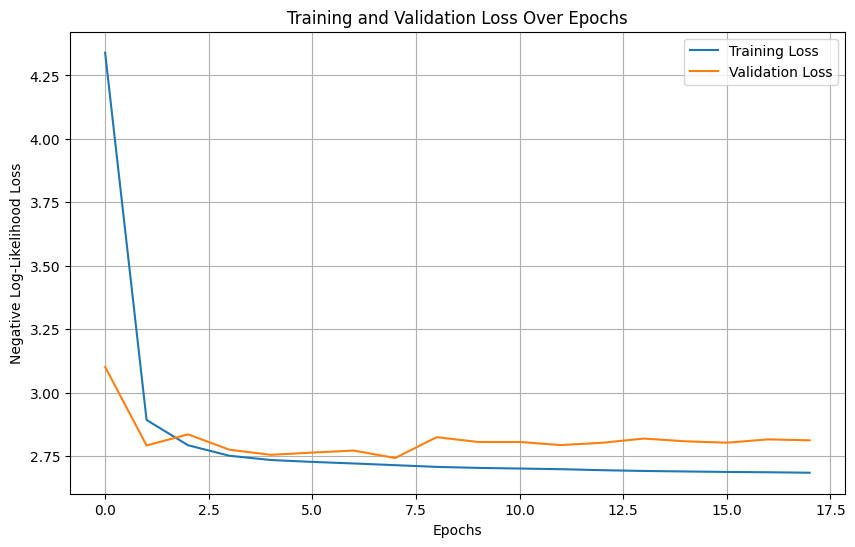

In [90]:
# plotting the losses
plot_training_validation_loss(loss_historytest3.losses, loss_historytest3.val_losses, title="Training and Validation Loss Over Epochs")

---

# IDN (just travels)

In [132]:
# Build the MLP-MDN model
def build_mlp_mdn_model(input_dim, output_dim, num_components):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(16, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    
    # Use the modified MDN layer
    mdn_outputs = mdn_layer(num_components, output_dim)(x)
    model = Model(inputs, mdn_outputs, name="MLP_MDN")

    # Define an exponential decay learning rate schedule
    initial_learning_rate = 1e-3
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=20000,  # Number of steps before decay
        decay_rate=0.50,   # Decay rate
        staircase=True     # If True, learning rate decreases in discrete intervals
    )

    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=mdn_loss(num_components, output_dim))
    return model

# Define the EarlyStopping callback 
early_stopping = CustomEarlyStopping( 
    monitor='val_loss', # Metric to monitor 
    patience=10, # Number of epochs to wait for improvement 
    threshold=3.0, # Restore the best weights after stopping 
    verbose=1, # Print messages when stopping 
    )

# Example usage
input_dim = 9  # Number of principal components (input features)
output_dim = 1  # Predicting a single target (travel time)
num_components = 6  # Number of Gaussian components in MDN

# Instantiate the callback
loss_history2jt = LossHistory()

model2jt = build_mlp_mdn_model(input_dim, output_dim, num_components)
model2jt.summary()


Model: "MLP_MDN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 16)        │        160 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 32)        │        544 │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_43[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 64)        │      2,112 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 128)       │      8,320 │ dense_44[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_45[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 64)        │      8,256 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 32)        │      2,080 │ dense_46[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_47[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 32)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 16)        │        528 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_48[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 16)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_weights     │ (None, 6)         │        102 │ dropout_27[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 6)         │          0 │ mixture_weights[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means (Dense)       │ (None, 6)         │        102 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variances (Dense)   │ (None, 6)         │        102 │ dropout_27[0][0]

 Total params: 23,138 (90.38 KB)

 Trainable params: 22,722 (88.76 KB)

 Non-trainable params: 416 (1.62 KB)

In [133]:
# Train the model2jt 
history2jt = model2jt.fit(
    x_train_pca_jt_np, y_train_np,
    validation_data=(x_val_pca_jt_np, y_val_np),
    epochs=100,
    batch_size=4096,
    verbose=1,
    callbacks=[loss_history2jt, early_stopping]
)



Epoch 1/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 119s 19ms/step - loss: 8.4287 - val_loss: 3.1230
Epoch 2/100
5918/5921 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.1077Threshold reached: val_loss = 2.9332. Starting early stopping monitoring.
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 105s 18ms/step - loss: 3.1077 - val_loss: 2.9332
Epoch 3/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 105s 18ms/step - loss: 2.9392 - val_loss: 2.9467
Epoch 4/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 105s 18ms/step - loss: 2.8993 - val_loss: 2.8763
Epoch 5/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 105s 18ms/step - loss: 2.8818 - val_loss: 2.8563
Epoch 6/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 105s 18ms/step - loss: 2.8737 - val_loss: 2.8731
Epoch 7/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 105s 18ms/step - loss: 2.8671 - val_loss: 2.8988
Epoch 8/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 104s 17ms/step - loss: 2.8592 - val_loss: 2.8613
Epoch 9/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 106s 18ms/step - loss: 2.8549 - val_loss: 2.8556
Epoch 10/100
5921/5921 ━━━━━━━━━━━━━━━━━

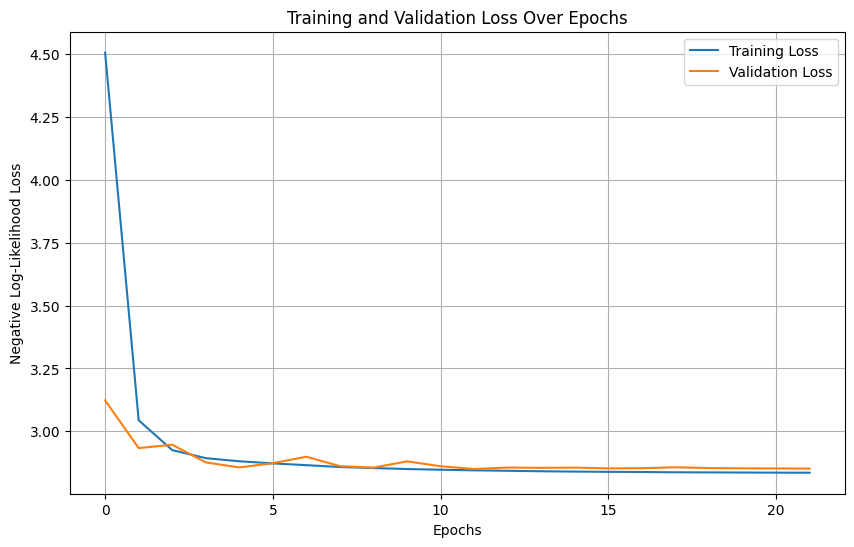

In [136]:
# plotting the losses
plot_training_validation_loss(loss_history2jt.losses, loss_history2jt.val_losses, title="Training and Validation Loss Over Epochs")

In [137]:
# Predict
y_pred2jt = model2jt.predict(x_test_pca_jt_np)

# Define the loss function again if needed
loss_fn = mdn_loss(num_components, output_dim)

# Compute the loss
test_loss = loss_fn(y_test_np, y_pred2jt)
print(f"Test Loss: {test_loss.numpy()}")

233160/233160 ━━━━━━━━━━━━━━━━━━━━ 168s 719us/step
Test Loss: 2.8511946201324463


In [138]:
# Set confidence level and limit the number of samples
CL = 0.95
sample_count = 100  # Compute for the first 100 samples

# Extract the first 100 predictions and corresponding ground truth
y_pred2jt_subset = y_pred2jt[:sample_count]
y_test_np_subset = np.array(y_test_np[:sample_count])

# Compute weighted predictions and confidence intervals for the subset
weighted_means2jt_subset, weighted_lower_bounds2jt_subset, weighted_upper_bounds2jt_subset = compute_final_predictions(
    y_pred2jt_subset, num_components, output_dim, confidence_level=CL
)

# Flatten the arrays for easy handling
weighted_means2jt_subset = weighted_means2jt_subset.flatten()
weighted_lower_bounds2jt_subset = weighted_lower_bounds2jt_subset.flatten()
weighted_upper_bounds2jt_subset = weighted_upper_bounds2jt_subset.flatten()

# Print results for each sample with ground truth
print(f"{'Sample':<10}{'Ground Truth':<15}{'Mean Prediction':<20}{'Confidence Interval':<30}{'Interval Range':<15}")
print("-" * 90)
for i in range(sample_count):
    interval_range = float(weighted_upper_bounds2jt_subset[i]) - float(weighted_lower_bounds2jt_subset[i])
    print(f"{i+1:<10}{float(y_test_np_subset[i]):<15.2f}{float(weighted_means2jt_subset[i]):<20.2f}"
          f"{f'{float(weighted_lower_bounds2jt_subset[i]):.2f} - {float(weighted_upper_bounds2jt_subset[i]):.2f}':<30}"
          f"{interval_range:<15.2f}")


Sample    Ground Truth   Mean Prediction     Confidence Interval           Interval Range 
------------------------------------------------------------------------------------------
1         18.42          17.95               10.44 - 25.47                 15.03          
2         9.63           8.08                4.40 - 11.78                  7.39           
3         14.47          25.39               11.55 - 39.23                 27.68          
4         33.35          47.13               26.46 - 67.80                 41.34          
5         9.00           8.46                4.71 - 12.23                  7.52           
6         8.02           12.89               7.40 - 18.38                  10.98          
7         7.05           8.39                4.38 - 12.43                  8.05           
8         7.70           11.71               4.97 - 18.44                  13.47          
9         15.02          21.50               11.65 - 31.34                 19.69          

---

# CBMLP(Simple MLP)

In [ ]:
# Build the MLP model
def build_mlp_model(input_dim, output_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(16, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)

    # Use ReLU activation for non-negative predictions
    outputs = layers.Dense(output_dim, activation="relu", name="output")(x)  # Enforces non-negative outputs
    model = Model(inputs, outputs, name="MLP")

    # Define an exponential decay learning rate schedule
    initial_learning_rate = 1e-3
    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=20000,  # Number of steps before decay
        decay_rate=0.50,    # Decay rate
        staircase=True      # If True, learning rate decreases in discrete intervals
    )

    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='mse')  # Use mean squared error loss for regression
    return model

# Define the EarlyStopping callback 
early_stopping = CustomEarlyStopping( 
    monitor='val_loss', # Metric to monitor 
    patience=10, # Number of epochs to wait for improvement 
    threshold=32, # Restore the best weights after stopping 
    verbose=1, # Print messages when stopping 
    )

input_dim = 27  # Number of principal components (input features)
output_dim = 1  # Predicting a single target (travel time)

# Instantiate the callback
loss_history3 = LossHistory()

# Build the MLP model
model3 = build_mlp_model(input_dim, output_dim)
model3.summary()


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,137 (90.38 KB)

 Trainable params: 22,721 (88.75 KB)

 Non-trainable params: 416 (1.62 KB)

In [135]:
# Train the model2jt 
history3 = model3.fit(
    x_train_pca_np, y_train_np,
    validation_data=(x_val_pca_np, y_val_np),
    epochs=100,
    batch_size=4096,
    verbose=1,
    callbacks=[loss_history3, early_stopping]
)



Epoch 1/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 96s 16ms/step - loss: 99.4432 - val_loss: 36.5128
Epoch 2/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 93s 15ms/step - loss: 38.8416 - val_loss: 34.9044
Epoch 3/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 92s 15ms/step - loss: 36.9196 - val_loss: 33.2668
Epoch 4/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 92s 15ms/step - loss: 35.6632 - val_loss: 32.7501
Epoch 5/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 92s 15ms/step - loss: 34.7581 - val_loss: 33.0048
Epoch 6/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 94s 16ms/step - loss: 34.3850 - val_loss: 31.7864
Epoch 7/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 92s 15ms/step - loss: 34.0904 - val_loss: 32.1346
Epoch 8/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 93s 15ms/step - loss: 33.7159 - val_loss: 32.8331
Epoch 9/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 92s 15ms/step - loss: 33.5245 - val_loss: 32.9545
Epoch 10/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 93s 16ms/step - loss: 33.4700 - val_loss: 32.6140
Epoch 11/100
5921/5921 ━━━━━━━━━━━━━━━━━━━━ 93s 16ms/step - loss: 33.

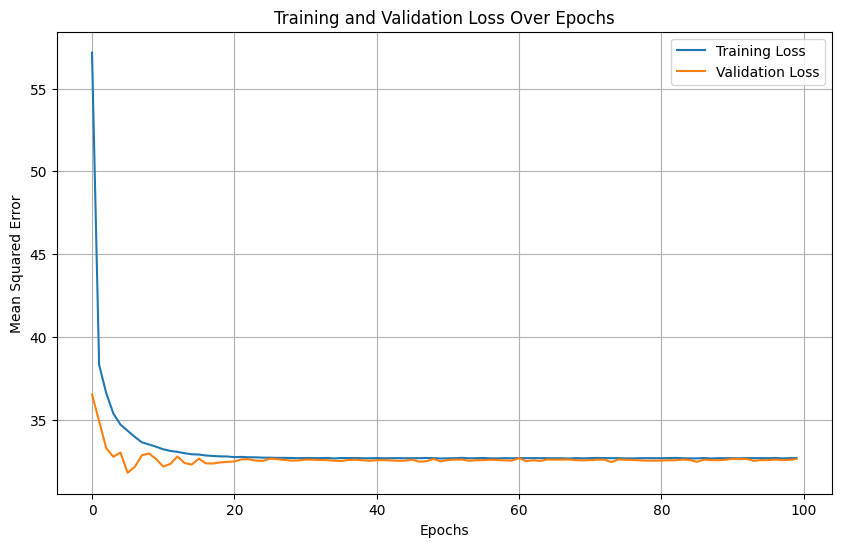

In [142]:
def plot_training_validation_loss(training_losses, validation_losses, title="Training and Validation"):
    """
    Plots the training and validation loss over epochs.

    Parameters:
    - training_losses: List of training loss values recorded per epoch.
    - validation_losses: List of validation loss values recorded per epoch.
    - title: Title of the plot (default: "Training and Validation Loss Over Epochs").
    """
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# plotting the losses
plot_training_validation_loss(loss_history3.losses, loss_history3.val_losses, title="Training and Validation Loss Over Epochs")

In [140]:
# Predict
y_pred3 = model3.predict(x_test_pca_np)


233160/233160 ━━━━━━━━━━━━━━━━━━━━ 152s 652us/step


In [141]:
# Set confidence level and limit the number of samples
CL = 0.95
sample_count = 100  # Compute for the first 100 samples

# Extract the first 100 predictions and corresponding ground truth
y_pred3_subset = y_pred3[:sample_count]
y_test_np_subset = np.array(y_test_np[:sample_count])


# Print results for each sample with ground truth
print(f"{'Sample':<10}{'Ground Truth':<15}{'Mean Prediction':<20}")
print("-" * 40)
for i in range(sample_count):
    print(f"{i+1:<10}{float(y_test_np_subset[i]):<15.2f}{float(y_pred3_subset[i]):<20.2f}")


Sample    Ground Truth   Mean Prediction     
----------------------------------------
1         18.42          20.21               
2         9.63           8.68                
3         14.47          24.87               
4         33.35          50.33               
5         9.00           9.83                
6         8.02           11.23               
7         7.05           7.22                
8         7.70           14.53               
9         15.02          18.13               
10        90.65          77.23               
11        10.43          12.55               
12        13.17          23.46               
13        13.53          12.79               
14        7.10           9.87                
15        9.38           8.64                
16        21.28          23.27               
17        10.97          13.44               
18        4.32           8.64                
19        13.43          6.61                
20        17.78          20.61         

C:\Users\A\AppData\Local\Temp\ipykernel_5692\19826667.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{i+1:<10}{float(y_test_np_subset[i]):<15.2f}{float(y_pred3_subset[i]):<20.2f}")


---

# comparing the models

In [158]:
# Compute final weighted predictions
CL = 0.95
weighted_means1, weighted_lower_bounds1, weighted_upper_bounds1 = compute_final_predictions(
    y_predtest2, num_components, output_dim, confidence_level=CL
)

weighted_means2, weighted_lower_bounds2, weighted_upper_bounds2 = compute_final_predictions(
    y_pred2jt, num_components, output_dim, confidence_level=CL
)




# Define error metrics
def rmsle(y_true, y_pred):
    y_true = np.maximum(y_true, 1e-6)
    y_pred = np.maximum(y_pred, 1e-6)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))


def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

# Ensure true and predicted values are 1D arrays
y_true = np.ravel(y_test_np)  # True values
y_pred1 = np.ravel(weighted_means1)  # MDN model with additional data
y_pred2 = np.ravel(weighted_means2)  # MDN model without additional data
y_pred3 = np.ravel(y_pred3)          # Simple MLP model

# Compute metrics for each model
metrics = {}
for y_pred, model_name in zip(
    [y_pred1, y_pred2, y_pred3], ["MDN Model 1", "MDN Model 2", "MLP Model"]
):
    metrics[model_name] = {
        "R2": r2_score(y_true, y_pred),
        "RMSLE": rmsle(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "MAE": mae(y_true, y_pred),
    }

# Print results
for model_name, errors in metrics.items():
    print(f"Errors for {model_name}:")
    for error_name, value in errors.items():
        print(f"  {error_name}: {value:.4f}")

Errors for MDN Model 1:
  R2: 0.7914
  RMSLE: 0.2975
  RMSE: 5.9826
  MAPE: 40.8376
  MAE: 3.5273
Errors for MDN Model 2:
  R2: 0.7364
  RMSLE: 0.3420
  RMSE: 6.7244
  MAPE: 42.8341
  MAE: 4.0143
Errors for MLP Model:
  R2: 0.8094
  RMSLE: 0.3015
  RMSE: 5.7179
  MAPE: 34.2386
  MAE: 3.5643


In [156]:


print(f"R^2 Score: {r2_score(y_true, y_pred3)}")


R^2 Score: 0.8094174861907959


In [144]:
print("Minimum y_true:", y_true.min())
print("Minimum y_pred1:", weighted_means1.min())
print("Minimum y_pred2:", weighted_means2.min())
print("Minimum y_pred3:", y_pred3.min())


Minimum y_true: 0.02
Minimum y_pred1: 0.5331083
Minimum y_pred2: 1.4792564
Minimum y_pred3: 0.0


In [ ]:
# for khune
losses = pd.read_excel('C:/Users/LENOVO/OneDrive/Desktop/my/data/traffic count/losses.xlsx')
# for uni
#losses = pd.read_excel('C:/Users/A/Desktop/Vaezi Shahin (private files)/thesis/data/losses.xlsx')

losses

C:\Users\A\AppData\Local\Temp\ipykernel_5692\2787075218.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='name', y='mape', palette='coolwarm')


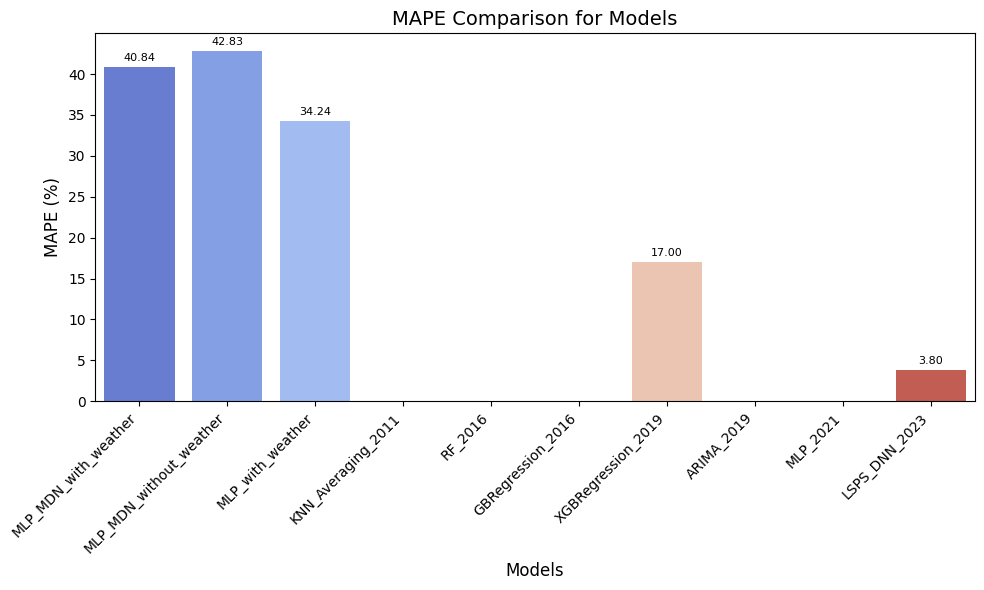

In [145]:
# Sample dataframe creation (replace this with your actual dataframe)
data = {
    'name': [
        'MLP_MDN_with_weather', 'MLP_MDN_without_weather', 'MLP_with_weather',
        'KNN_Averaging_2011', 'RF_2016', 'GBRegression_2016',
        'XGBRegression_2019', 'ARIMA_2019', 'MLP_2021', 'LSPS_DNN_2023'
    ],
    'mape': [40.8376, 42.8341, 34.2386, None, None, None, 17.000, None, None, 3.800],
}
df = pd.DataFrame(data)

# Create a bar plot for MAPE
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='name', y='mape', palette='coolwarm')

# Add data labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8, padding=3)

# Add labels and formatting
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)
plt.title('MAPE Comparison for Models', fontsize=14)
plt.tight_layout()
plt.show()


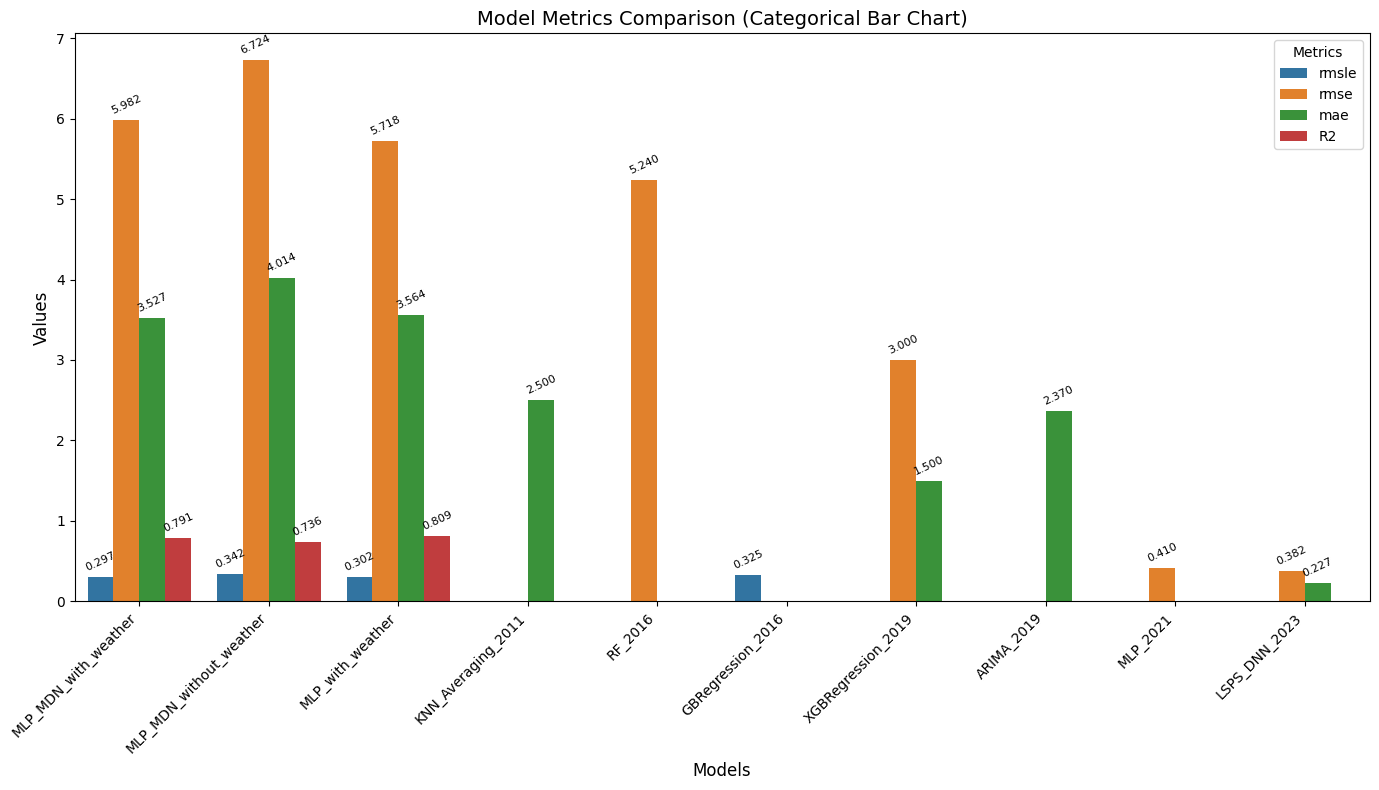

In [162]:
# Sample dataframe creation (replace this with your actual dataframe)
data = {
    'name': [
        'MLP_MDN_with_weather', 'MLP_MDN_without_weather', 'MLP_with_weather',
        'KNN_Averaging_2011', 'RF_2016', 'GBRegression_2016',
        'XGBRegression_2019', 'ARIMA_2019', 'MLP_2021', 'LSPS_DNN_2023'
    ],
    'rmsle': [0.297, 0.342, 0.302, None, None, 0.325, None, None, None, None],
    'rmse': [5.982, 6.724, 5.718, None, 5.240, None, 3.000, None, 0.410, 0.382],
    'mae': [3.527, 4.014, 3.564, 2.500, None, None, 1.500, 2.370, None, 0.227],
    'R2': [0.791, 0.736, 0.809, None, None, None, None, None, None, None]
}
df = pd.DataFrame(data)

# Melt the dataframe to prepare for categorical plotting (exclude mape)
df_melted = df.melt(id_vars=['name'], value_vars=['rmsle', 'rmse', 'mae', 'R2'],
                    var_name='Metric', value_name='Value')

# Create the categorical bar plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df_melted, x='name', y='Value', hue='Metric', palette='tab10')

# Add data labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=8, padding=3, rotation=25)

# Add labels and formatting
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Model Metrics Comparison (Categorical Bar Chart)', fontsize=14)
plt.legend(title='Metrics', loc='upper right')
plt.tight_layout()
plt.show()
